In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image

# This is needed to display the images.
%matplotlib inline

In [2]:
PATH_TO_TEST_IMAGES_DIR = 'test_img'
PATH_TO_IMAGES_DIR = 'img/img'
PATH_TO_CUTED_IMAGES = 'cut_img'
FEATURES_DIR = 'features'
IMAGE_PATHS = list(map(lambda x: PATH_TO_IMAGES_DIR + '/' + x, os.listdir(PATH_TO_IMAGES_DIR)))
backup_last_index_file_name = 'backup.txt'
backup_last_index_path = PATH_TO_CUTED_IMAGES + '/' + backup_last_index_file_name
last_index = 0
print(IMAGE_PATHS[0])
print(len(IMAGE_PATHS))

img/img/img_00000015.jpg
123002


In [3]:
# What model to download.
MODEL_NAME = 'clothes_detection'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'labelmap.pbtxt'

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
def load_image_into_numpy_array(image):
  im_width, im_height = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [7]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_img'
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 6) ]
TEST_IMAGE_PATHS = os.listdir(PATH_TO_TEST_IMAGES_DIR)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [8]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [9]:
def box2cords(box, width, height):
    ymin = int(box[0]*height)
    xmin = int(box[1]*width)
    ymax = int(box[2]*height)
    xmax = int(box[3]*width)
    return ymin, xmin, ymax, xmax

img/img/img_00000017.jpg


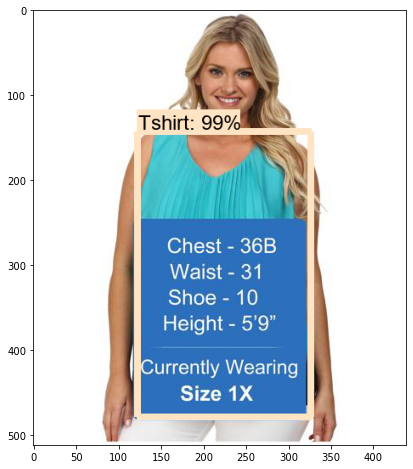

In [10]:

for image_path in IMAGE_PATHS[2:]:
    print(image_path)
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    break

In [11]:
import sys

import cv2
import numpy as np


def quantify_colors(img, k=32, attempts=5):
    """
    :param img: An array of N-Dimensional points with int coordinates is needed.
    :param k: int
    :param attempts: int
    """
    float_pixels = np.float32(img)
    float_pixels = float_pixels.reshape((float_pixels.shape[0] * float_pixels.shape[1], 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(float_pixels, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    ret = center[label.flatten()]
    ret = ret.reshape(img.shape)
    return ret


# https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
def plot_colors(data):
    """
    :param data: (cluster names, cluster colors, cluster histogram)
    :return:
    """
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    start_x = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (_, color, percent) in data:
        # plot the relative percentage of each cluster
        end_x = start_x + (percent * 300)
        cv2.rectangle(bar, (int(start_x), 0), (int(end_x), 50),
                      color.astype("uint8").tolist(), -1)
        start_x = end_x

    # return the bar chart
    return bar


# https://stackoverflow.com/a/47542304/513723
# definitely read this ^^ answer it's very useful!
def distance_sq(left, right):
    """ Returns the square of the distance between left and right. """
    return (
            ((int(left[0]) - int(right[0])) ** 2) +
            ((int(left[1]) - int(right[1])) ** 2) +
            ((int(left[2]) - int(right[2])) ** 2)
    )


# https://stackoverflow.com/a/47542304/513723
# definitely read this ^^ answer it's very useful!
def distance(left, right):
    """ Returns the distance between left and right. """
    return (((int(left[0]) - int(right[0])) ** 2) +
            ((int(left[1]) - int(right[1])) ** 2) +
            ((int(left[2]) - int(right[2])) ** 2)
            ) ** .5


# https://stackoverflow.com/a/34325723/513723
# https://gist.github.com/aubricus/f91fb55dc6ba5557fbab06119420dd6a
# Print iterations progress
def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()


def new_image_size(orig_width, orig_height, smallest_side_size):
    new_w = orig_width
    new_h = orig_height
    if smallest_side_size <= 0:
        return new_w, new_h

    if orig_width > orig_height:
        new_h = smallest_side_size
        new_w = round(orig_width * new_h / orig_height)
    else:
        new_w = smallest_side_size
        new_h = round(orig_height * new_w / orig_width)

    return new_w, new_h

In [16]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
def rembg(path):
    smallestSideSize = 500
    # real would be thicker because of masking process
    mainRectSize = .04
    fgSize = .15

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width = img.shape[:2]
    new_w, new_h = new_image_size(width, height, smallestSideSize)

    # resize image to lower resources usage
    # if you need masked image in original size, do not resize it
    img_small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # quantify colors
    img_small = quantify_colors(img_small, 32, 10)

    # create mask tpl
    mask = np.zeros(img_small.shape[:2], np.uint8)

    # create BG rect
    bg_w = round(new_w * mainRectSize)
    bg_h = round(new_h * mainRectSize)
    bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)

    # create FG rect
    fg_w = round(new_w * (1 - fgSize) / 2)
    fg_h = round(new_h * (1 - fgSize) / 2)
    fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)

    # color: 0 - bg, 1 - fg, 2 - probable bg, 3 - probable fg
    cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)

    mask_preset = mask.copy()

    bgdModel1 = np.zeros((1, 65), np.float64)
    fgdModel1 = np.zeros((1, 65), np.float64)

    cv2.grabCut(img_small, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
    mask_rect = mask.copy()

    cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
    cv2.grabCut(img_small, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)
    mask_mask = mask.copy()

    # mask to remove background
    mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')

    # if we are removing too much, assume there is no background
    unique, counts = np.unique(mask_result, return_counts=True)
    mask_dict = dict(zip(unique, counts))

    if mask_dict[0] > mask_dict[255] * 1.6:
        mask_result = np.where((mask == 0) + (mask != 1) + (mask != 3), 255, 0).astype('uint8')

    # apply mask to image
    masked = cv2.bitwise_and(img_small, img_small, mask=mask_result)
    masked[mask_result < 2] = [255, 255, 255]  # change black bg to blue

    # draw rect on original image
    cv2.rectangle(img_small, bg_rect[:2], bg_rect[2:4], (255, 0, 0), 2)
    cv2.rectangle(img_small, fg_rect[:2], fg_rect[2:4], (0, 255, 0), 2, cv2.FILLED)
    
    plt.subplot(2, 3, 1), plt.imshow(img_small), plt.title("Orig img with preset")
    plt.subplot(2, 3, 2), plt.imshow(mask_result), plt.title("Final Mask")
    plt.subplot(2, 3, 3), plt.imshow(masked), plt.title("Result")
    plt.subplot(2, 3, 4), plt.imshow(mask_preset), plt.title("Mask preset FG")
    plt.subplot(2, 3, 5), plt.imshow(mask_rect), plt.title("GC_INIT_WITH_RECT")
    plt.subplot(2, 3, 6), plt.imshow(mask_mask), plt.title("GC_INIT_WITH_MASK")

#     plt.show()
    
    return masked

In [17]:
# %matplotlib inline
# image_path = r"D:\Documents\Programming\ML\IT-Planet_OCR\Part3\test_img\img_00000001.jpg"
# image = load_image_into_numpy_array(Image.open(image_path))
# # the array based representation of the image will be used later in order to prepare the
# # result image with boxes and labels on it.
# image_np = rembg(image_path)

# cv2.resize(image, (image_np.shape[0], image_np.shape[1]), interpolation = cv2.INTER_AREA)

# # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
# image_np_expanded = np.expand_dims(image_np, axis=0)
# # Actual detection.
# output_dict = run_inference_for_single_image(image_np, detection_graph)
# # Visualization of the results of a detection.
# vis_util.visualize_boxes_and_labels_on_image_array(
#   image,
#   output_dict['detection_boxes'],
#   output_dict['detection_classes'],
#   output_dict['detection_scores'],
#   category_index,
#   instance_masks=output_dict.get('detection_masks'),
#   use_normalized_coordinates=True,
#   line_thickness=8)
# plt.figure(figsize=IMAGE_SIZE)
# plt.imshow(image)
# print(output_dict['detection_boxes'])

{1: {'id': 1, 'name': 'dress'}, 2: {'id': 2, 'name': 'shirt'}, 3: {'id': 3, 'name': 'skirt'}, 4: {'id': 4, 'name': 'jacket'}, 5: {'id': 5, 'name': 'coat'}, 6: {'id': 6, 'name': 'Tshirt'}, 7: {'id': 7, 'name': 'shorts'}, 8: {'id': 8, 'name': 'boots'}, 9: {'id': 9, 'name': 'trousers'}, 10: {'id': 10, 'name': 'sunglasses'}, 11: {'id': 11, 'name': 'shoes'}, 12: {'id': 12, 'name': 'sportshoes'}} 

last_index =  1 



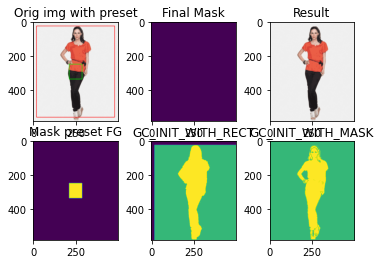

In [18]:
# %matplotlib inline
# image_path = r"D:\Projects\Python_Projects\IT-PLANET 3.0\test3.jpg"
# image = load_image_into_numpy_array(Image.open(image_path))
# # the array based representation of the image will be used later in order to prepare the
# # result image with boxes and labels on it.
# image_np = rembg(image_path)

# cv2.resize(image, (image_np.shape[0], image_np.shape[1]), interpolation = cv2.INTER_AREA)

# # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
# image_np_expanded = np.expand_dims(image_np, axis=0)
# # Actual detection.
# output_dict = run_inference_for_single_image(image_np, detection_graph)
# # Visualization of the results of a detection.
# vis_util.visualize_boxes_and_labels_on_image_array(
#   image,
#   output_dict['detection_boxes'],
#   output_dict['detection_classes'],
#   output_dict['detection_scores'],
#   category_index,
#   instance_masks=output_dict.get('detection_masks'),
#   use_normalized_coordinates=True,
#   line_thickness=8)
# plt.figure(figsize=IMAGE_SIZE)
# plt.imshow(image)
# print(output_dict['detection_classes'])
print(category_index, '\n')
if not os.path.exists(backup_last_index_path):
    backup_file = open(backup_last_index_path, "w")
    backup_file.write('0')
    backup_file.close()
else:
    backup_file = open(backup_last_index_path, "r")
    last_index = int(backup_file.readline()) + 1
    backup_file.close()
    
print('last_index = ', last_index, '\n')    

for i, img_path in enumerate(sorted(IMAGE_PATHS[last_index:401])):
    image = load_image_into_numpy_array(Image.open(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rembg = rembg(img_path)
    break
    cv2.resize(image, (image_rembg.shape[0], image_rembg.shape[1]), interpolation = cv2.INTER_AREA)
    image_rembg_expanded = np.expand_dims(image_rembg, axis=0)
    output_dict = run_inference_for_single_image(image_rembg, detection_graph)
    index_of_max_score = np.where(output_dict['detection_scores'] == max(output_dict['detection_scores']))
    box_with_max_score = output_dict['detection_boxes'][index_of_max_score][0]
#     print('box_with_max_score', box_with_max_score)
    ymin, xmin, ymax, xmax = box2cords(box_with_max_score, image.shape[1], image.shape[0])
    image_cutted = image[ymin:ymax, xmin:xmax]
    class_path = category_index[output_dict['detection_classes'][index_of_max_score][0]]['name']
#     print('class_path', class_path)
    
    path_to_folder = PATH_TO_CUTED_IMAGES + '/' + str(class_path) 
#     print(path_to_folder)
    if not os.path.exists(path_to_folder):
        os.mkdir(path_to_folder)
    path_to_image = path_to_folder + '/' + img_path.split('/')[-1]
#     cv2.imshow('asdas', image_cutted)
#     cv2.waitKey(0)
    print(last_index + i, path_to_image)
    # backup last index
    backup_file = open(backup_last_index_path, "w")
    backup_file.write(str(last_index + i))
    backup_file.close()
    
    cv2.imwrite(path_to_image, image_cutted)

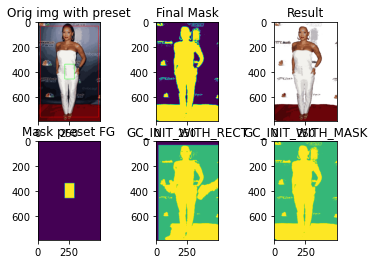

In [21]:
img_path = 'img/img/img_00000188.jpg'
image = load_image_into_numpy_array(Image.open(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rembg = rembg(img_path)

# Визуальный поиск

In [40]:
# Import the libraries
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)
# Iterate through images (Change the path based on your image location)

In [99]:
# print(os.listdir(PATH_TO_TEST_IMAGES_DIR))
# list(map(lambda x: PATH_TO_TEST_IMAGES_DIR + x, os.listdir(PATH_TO_TEST_IMAGES_DIR)))
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 6) ]
# print(PATH_TO_CUTED_IMAGES)
cut_dirs_classes = os.listdir(PATH_TO_CUTED_IMAGES)
cut_dirs_classes.remove(backup_last_index_file_name)

if not os.path.exists(FEATURES_DIR):
    os.mkdir(FEATURES_DIR)

for folder in cut_dirs_classes:
    path_to_folder =  PATH_TO_CUTED_IMAGES + '/' + folder
#     folder_files = list(map(lambda x: path_to_folder + '/' + x, os.listdir(path_to_folder)))
    
    for img_path in sorted(os.listdir(path_to_folder)):
        full_img_path = path_to_folder + '/' + img_path
        # Extract Features
        feature = fe.extract(img=Image.open(full_img_path))
        # Save the Numpy array (.npy) on designated path
        feature_dir = FEATURES_DIR + '/' + folder
        feature_path = feature_dir + '/' + img_path.split('.')[0] + ".npy"
        print(feature_path)
        if not os.path.exists(feature_dir):
            os.mkdir(feature_dir)
        np.save(feature_path, feature)

features/boots/img_00000088.npy
features/boots/img_00000173.npy
features/boots/img_00000181.npy
features/boots/img_00000221.npy
features/dress/img_00000018.npy
features/dress/img_00000029.npy
features/dress/img_00000039.npy
features/dress/img_00000040.npy
features/dress/img_00000044.npy
features/dress/img_00000049.npy
features/dress/img_00000056.npy
features/dress/img_00000057.npy
features/dress/img_00000060.npy
features/dress/img_00000064.npy
features/dress/img_00000067.npy
features/dress/img_00000071.npy
features/dress/img_00000078.npy
features/dress/img_00000080.npy
features/dress/img_00000083.npy
features/dress/img_00000084.npy
features/dress/img_00000094.npy
features/dress/img_00000098.npy
features/dress/img_00000100.npy
features/dress/img_00000107.npy
features/dress/img_00000109.npy
features/dress/img_00000111.npy
features/dress/img_00000112.npy
features/dress/img_00000113.npy
features/dress/img_00000115.npy
features/dress/img_00000117.npy
features/dress/img_00000119.npy
features

features/shirt/img_00000289.npy
features/shirt/img_00000290.npy
features/shirt/img_00000291.npy
features/shirt/img_00000292.npy
features/shirt/img_00000293.npy
features/shirt/img_00000294.npy
features/shirt/img_00000295.npy
features/shirt/img_00000296.npy
features/shirt/img_00000297.npy
features/shirt/img_00000298.npy
features/shirt/img_00000299.npy
features/shirt/img_00000300.npy
features/shirt/img_00000301.npy
features/shirt/img_00000306.npy
features/shirt/img_00000309.npy
features/shirt/img_00000312.npy
features/shirt/img_00000313.npy
features/shirt/img_00000318.npy
features/shirt/img_00000320.npy
features/shirt/img_00000322.npy
features/shirt/img_00000323.npy
features/shirt/img_00000324.npy
features/shirt/img_00000325.npy
features/shirt/img_00000326.npy
features/shirt/img_00000333.npy
features/shirt/img_00000334.npy
features/shirt/img_00000335.npy
features/shirt/img_00000336.npy
features/shirt/img_00000337.npy
features/shirt/img_00000339.npy
features/shirt/img_00000340.npy
features

In [6]:
# print(os.listdir(PATH_TO_TEST_IMAGES_DIR))
# # list(map(lambda x: PATH_TO_TEST_IMAGES_DIR + x, os.listdir(PATH_TO_TEST_IMAGES_DIR)))
# # TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 6) ]
# print(TEST_IMAGE_PATHS)
# for i, img_path in enumerate(sorted(TEST_IMAGE_PATHS)):
#     print(img_path)
#     # Extract Features
#     feature = fe.extract(img=Image.open(img_path))
#     # Save the Numpy array (.npy) on designated path
#     feature_path = "features/feature_path" + str(i) + ".npy"
#     np.save(feature_path, feature)

['img_00000015.jpg', 'img_00000016.jpg', 'img_00000017.jpg', 'img_00000018.jpg', 'img_00000019.jpg', 'img_00000020.jpg', 'img_00000021.jpg', 'img_00000022.jpg', 'img_00000023.jpg', 'img_00000024.jpg', 'img_00000025.jpg', 'img_00000026.jpg', 'img_00000027.jpg', 'img_00000028.jpg', 'img_00000029.jpg', 'img_00000030.jpg', 'img_00000031.jpg', 'img_00000032.jpg', 'img_00000033.jpg', 'img_00000034.jpg', 'img_00000035.jpg', 'img_00000036.jpg', 'img_00000037.jpg', 'img_00000038.jpg', 'img_00000039.jpg', 'img_00000040.jpg', 'img_00000041.jpg', 'img_00000042.jpg', 'img_00000043.jpg', 'img_00000044.jpg', 'img_00000045.jpg', 'img_00000046.jpg', 'img_00000047.jpg', 'img_00000048.jpg', 'img_00000049.jpg', 'img_00000050.jpg', 'img_00000051.jpg', 'img_00000052.jpg', 'img_00000053.jpg', 'img_00000054.jpg', 'img_00000055.jpg', 'img_00000056.jpg', 'img_00000057.jpg', 'img_00000058.jpg', 'img_00000059.jpg', 'img_00000060.jpg', 'img_00000061.jpg', 'img_00000062.jpg', 'img_00000063.jpg', 'img_00000064.jpg',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



img/img/img_00000031.jpg
img/img/img_00000032.jpg
img/img/img_00000033.jpg
img/img/img_00000034.jpg
img/img/img_00000035.jpg
img/img/img_00000036.jpg
img/img/img_00000037.jpg
img/img/img_00000038.jpg
img/img/img_00000039.jpg
img/img/img_00000040.jpg
img/img/img_00000041.jpg
img/img/img_00000042.jpg
img/img/img_00000043.jpg
img/img/img_00000044.jpg
img/img/img_00000045.jpg
img/img/img_00000046.jpg
img/img/img_00000047.jpg
img/img/img_00000048.jpg
img/img/img_00000049.jpg
img/img/img_00000050.jpg
img/img/img_00000051.jpg
img/img/img_00000052.jpg
img/img/img_00000053.jpg
img/img/img_00000054.jpg
img/img/img_00000055.jpg
img/img/img_00000056.jpg
img/img/img_00000057.jpg
img/img/img_00000058.jpg
img/img/img_00000059.jpg
img/img/img_00000060.jpg
img/img/img_00000061.jpg
img/img/img_00000062.jpg
img/img/img_00000063.jpg
img/img/img_00000064.jpg
img/img/img_00000065.jpg
img/img/img_00000066.jpg
img/img/img_00000067.jpg
img/img/img_00000068.jpg
img/img/img_00000069.jpg
img/img/img_00000070.jpg


img/img/img_00000360.jpg
img/img/img_00000361.jpg
img/img/img_00000362.jpg
img/img/img_00000363.jpg
img/img/img_00000364.jpg
img/img/img_00000365.jpg
img/img/img_00000366.jpg
img/img/img_00000367.jpg
img/img/img_00000368.jpg
img/img/img_00000369.jpg
img/img/img_00000370.jpg
img/img/img_00000371.jpg
img/img/img_00000372.jpg
img/img/img_00000373.jpg
img/img/img_00000374.jpg
img/img/img_00000375.jpg
img/img/img_00000376.jpg
img/img/img_00000377.jpg
img/img/img_00000378.jpg
img/img/img_00000379.jpg
img/img/img_00000380.jpg
img/img/img_00000381.jpg
img/img/img_00000382.jpg
img/img/img_00000383.jpg
img/img/img_00000384.jpg
img/img/img_00000385.jpg
img/img/img_00000386.jpg
img/img/img_00000387.jpg
img/img/img_00000388.jpg
img/img/img_00000389.jpg
img/img/img_00000390.jpg
img/img/img_00000391.jpg
img/img/img_00000392.jpg
img/img/img_00000393.jpg
img/img/img_00000394.jpg
img/img/img_00000395.jpg
img/img/img_00000396.jpg
img/img/img_00000397.jpg
img/img/img_00000398.jpg
img/img/img_00000399.jpg


img/img/img_00000689.jpg
img/img/img_00000690.jpg
img/img/img_00000691.jpg
img/img/img_00000692.jpg
img/img/img_00000693.jpg
img/img/img_00000694.jpg
img/img/img_00000695.jpg
img/img/img_00000696.jpg
img/img/img_00000697.jpg
img/img/img_00000698.jpg
img/img/img_00000699.jpg
img/img/img_00000700.jpg
img/img/img_00000701.jpg
img/img/img_00000702.jpg
img/img/img_00000703.jpg
img/img/img_00000704.jpg
img/img/img_00000705.jpg
img/img/img_00000706.jpg
img/img/img_00000707.jpg
img/img/img_00000708.jpg
img/img/img_00000709.jpg
img/img/img_00000710.jpg
img/img/img_00000711.jpg
img/img/img_00000712.jpg
img/img/img_00000713.jpg
img/img/img_00000714.jpg
img/img/img_00000715.jpg
img/img/img_00000716.jpg
img/img/img_00000717.jpg
img/img/img_00000718.jpg
img/img/img_00000719.jpg
img/img/img_00000720.jpg
img/img/img_00000721.jpg
img/img/img_00000722.jpg
img/img/img_00000723.jpg
img/img/img_00000724.jpg
img/img/img_00000725.jpg
img/img/img_00000726.jpg
img/img/img_00000727.jpg
img/img/img_00000728.jpg


img/img/img_00001018.jpg
img/img/img_00001019.jpg
img/img/img_00001020.jpg
img/img/img_00001021.jpg
img/img/img_00001022.jpg
img/img/img_00001023.jpg
img/img/img_00001024.jpg
img/img/img_00001025.jpg
img/img/img_00001026.jpg
img/img/img_00001027.jpg
img/img/img_00001028.jpg
img/img/img_00001029.jpg
img/img/img_00001030.jpg
img/img/img_00001031.jpg
img/img/img_00001032.jpg
img/img/img_00001033.jpg
img/img/img_00001034.jpg
img/img/img_00001035.jpg
img/img/img_00001036.jpg
img/img/img_00001037.jpg
img/img/img_00001038.jpg
img/img/img_00001039.jpg
img/img/img_00001040.jpg
img/img/img_00001041.jpg
img/img/img_00001042.jpg
img/img/img_00001043.jpg
img/img/img_00001044.jpg
img/img/img_00001045.jpg
img/img/img_00001046.jpg
img/img/img_00001047.jpg
img/img/img_00001048.jpg
img/img/img_00001049.jpg
img/img/img_00001050.jpg
img/img/img_00001051.jpg
img/img/img_00001052.jpg
img/img/img_00001053.jpg
img/img/img_00001054.jpg
img/img/img_00001055.jpg
img/img/img_00001056.jpg
img/img/img_00001057.jpg


img/img/img_00001346.jpg
img/img/img_00001347.jpg
img/img/img_00001348.jpg
img/img/img_00001349.jpg
img/img/img_00001350.jpg
img/img/img_00001351.jpg
img/img/img_00001352.jpg
img/img/img_00001353.jpg
img/img/img_00001354.jpg
img/img/img_00001355.jpg
img/img/img_00001356.jpg
img/img/img_00001357.jpg
img/img/img_00001358.jpg
img/img/img_00001359.jpg
img/img/img_00001360.jpg
img/img/img_00001361.jpg
img/img/img_00001362.jpg
img/img/img_00001363.jpg
img/img/img_00001364.jpg
img/img/img_00001365.jpg
img/img/img_00001366.jpg
img/img/img_00001367.jpg
img/img/img_00001368.jpg
img/img/img_00001369.jpg
img/img/img_00001370.jpg
img/img/img_00001371.jpg
img/img/img_00001372.jpg
img/img/img_00001373.jpg
img/img/img_00001374.jpg
img/img/img_00001375.jpg
img/img/img_00001376.jpg
img/img/img_00001377.jpg
img/img/img_00001378.jpg
img/img/img_00001379.jpg
img/img/img_00001380.jpg
img/img/img_00001381.jpg
img/img/img_00001382.jpg
img/img/img_00001383.jpg
img/img/img_00001384.jpg
img/img/img_00001385.jpg


img/img/img_00001675.jpg
img/img/img_00001676.jpg
img/img/img_00001677.jpg
img/img/img_00001678.jpg
img/img/img_00001679.jpg
img/img/img_00001680.jpg
img/img/img_00001681.jpg
img/img/img_00001682.jpg
img/img/img_00001683.jpg
img/img/img_00001684.jpg
img/img/img_00001685.jpg
img/img/img_00001686.jpg
img/img/img_00001687.jpg
img/img/img_00001688.jpg
img/img/img_00001689.jpg
img/img/img_00001690.jpg
img/img/img_00001691.jpg
img/img/img_00001692.jpg
img/img/img_00001693.jpg
img/img/img_00001694.jpg
img/img/img_00001695.jpg
img/img/img_00001696.jpg
img/img/img_00001697.jpg
img/img/img_00001698.jpg
img/img/img_00001699.jpg
img/img/img_00001700.jpg
img/img/img_00001701.jpg
img/img/img_00001702.jpg
img/img/img_00001703.jpg
img/img/img_00001704.jpg
img/img/img_00001705.jpg
img/img/img_00001706.jpg
img/img/img_00001707.jpg
img/img/img_00001708.jpg
img/img/img_00001709.jpg
img/img/img_00001710.jpg
img/img/img_00001711.jpg
img/img/img_00001712.jpg
img/img/img_00001713.jpg
img/img/img_00001714.jpg


img/img/img_00002004.jpg
img/img/img_00002005.jpg
img/img/img_00002006.jpg
img/img/img_00002007.jpg
img/img/img_00002008.jpg
img/img/img_00002009.jpg
img/img/img_00002010.jpg
img/img/img_00002011.jpg
img/img/img_00002012.jpg
img/img/img_00002013.jpg
img/img/img_00002014.jpg
img/img/img_00002015.jpg
img/img/img_00002016.jpg
img/img/img_00002017.jpg
img/img/img_00002018.jpg
img/img/img_00002019.jpg
img/img/img_00002020.jpg
img/img/img_00002021.jpg
img/img/img_00002022.jpg
img/img/img_00002023.jpg
img/img/img_00002024.jpg
img/img/img_00002025.jpg
img/img/img_00002026.jpg
img/img/img_00002027.jpg
img/img/img_00002028.jpg
img/img/img_00002029.jpg
img/img/img_00002030.jpg
img/img/img_00002031.jpg
img/img/img_00002032.jpg
img/img/img_00002033.jpg
img/img/img_00002034.jpg
img/img/img_00002035.jpg
img/img/img_00002036.jpg
img/img/img_00002037.jpg
img/img/img_00002038.jpg
img/img/img_00002039.jpg
img/img/img_00002040.jpg
img/img/img_00002041.jpg
img/img/img_00002042.jpg
img/img/img_00002043.jpg


img/img/img_00002333.jpg
img/img/img_00002334.jpg
img/img/img_00002335.jpg
img/img/img_00002336.jpg
img/img/img_00002337.jpg
img/img/img_00002338.jpg
img/img/img_00002339.jpg
img/img/img_00002340.jpg
img/img/img_00002341.jpg
img/img/img_00002342.jpg
img/img/img_00002343.jpg
img/img/img_00002344.jpg
img/img/img_00002345.jpg
img/img/img_00002346.jpg
img/img/img_00002347.jpg
img/img/img_00002348.jpg
img/img/img_00002349.jpg
img/img/img_00002350.jpg
img/img/img_00002351.jpg
img/img/img_00002352.jpg
img/img/img_00002353.jpg
img/img/img_00002354.jpg
img/img/img_00002355.jpg
img/img/img_00002356.jpg
img/img/img_00002357.jpg
img/img/img_00002358.jpg
img/img/img_00002359.jpg
img/img/img_00002360.jpg
img/img/img_00002361.jpg
img/img/img_00002362.jpg
img/img/img_00002363.jpg
img/img/img_00002364.jpg
img/img/img_00002365.jpg
img/img/img_00002366.jpg
img/img/img_00002367.jpg
img/img/img_00002368.jpg
img/img/img_00002369.jpg
img/img/img_00002370.jpg
img/img/img_00002371.jpg
img/img/img_00002372.jpg


img/img/img_00002661.jpg
img/img/img_00002662.jpg
img/img/img_00002663.jpg
img/img/img_00002664.jpg
img/img/img_00002665.jpg
img/img/img_00002666.jpg
img/img/img_00002667.jpg
img/img/img_00002668.jpg
img/img/img_00002669.jpg
img/img/img_00002670.jpg
img/img/img_00002671.jpg
img/img/img_00002672.jpg
img/img/img_00002673.jpg
img/img/img_00002674.jpg
img/img/img_00002675.jpg
img/img/img_00002676.jpg
img/img/img_00002677.jpg
img/img/img_00002678.jpg
img/img/img_00002679.jpg
img/img/img_00002680.jpg
img/img/img_00002681.jpg
img/img/img_00002682.jpg
img/img/img_00002683.jpg
img/img/img_00002684.jpg
img/img/img_00002685.jpg
img/img/img_00002686.jpg
img/img/img_00002687.jpg
img/img/img_00002688.jpg
img/img/img_00002689.jpg
img/img/img_00002690.jpg
img/img/img_00002691.jpg
img/img/img_00002692.jpg
img/img/img_00002693.jpg
img/img/img_00002694.jpg
img/img/img_00002695.jpg
img/img/img_00002696.jpg
img/img/img_00002697.jpg
img/img/img_00002698.jpg
img/img/img_00002699.jpg
img/img/img_00002700.jpg


img/img/img_00002990.jpg
img/img/img_00002991.jpg
img/img/img_00002992.jpg
img/img/img_00002993.jpg
img/img/img_00002994.jpg
img/img/img_00002995.jpg
img/img/img_00002996.jpg
img/img/img_00002997.jpg
img/img/img_00002998.jpg
img/img/img_00002999.jpg
img/img/img_00003000.jpg
img/img/img_00003001.jpg
img/img/img_00003002.jpg
img/img/img_00003003.jpg
img/img/img_00003004.jpg
img/img/img_00003005.jpg
img/img/img_00003006.jpg
img/img/img_00003007.jpg
img/img/img_00003008.jpg
img/img/img_00003009.jpg
img/img/img_00003010.jpg
img/img/img_00003011.jpg
img/img/img_00003012.jpg
img/img/img_00003013.jpg
img/img/img_00003014.jpg
img/img/img_00003015.jpg
img/img/img_00003016.jpg
img/img/img_00003017.jpg
img/img/img_00003018.jpg
img/img/img_00003019.jpg
img/img/img_00003020.jpg
img/img/img_00003021.jpg
img/img/img_00003022.jpg
img/img/img_00003023.jpg
img/img/img_00003024.jpg
img/img/img_00003025.jpg
img/img/img_00003026.jpg
img/img/img_00003027.jpg
img/img/img_00003028.jpg
img/img/img_00003029.jpg


img/img/img_00003319.jpg
img/img/img_00003320.jpg
img/img/img_00003321.jpg
img/img/img_00003322.jpg
img/img/img_00003323.jpg
img/img/img_00003324.jpg
img/img/img_00003325.jpg
img/img/img_00003326.jpg
img/img/img_00003327.jpg
img/img/img_00003328.jpg
img/img/img_00003329.jpg
img/img/img_00003330.jpg
img/img/img_00003331.jpg
img/img/img_00003332.jpg
img/img/img_00003333.jpg
img/img/img_00003334.jpg
img/img/img_00003335.jpg
img/img/img_00003336.jpg
img/img/img_00003337.jpg
img/img/img_00003338.jpg
img/img/img_00003339.jpg
img/img/img_00003340.jpg
img/img/img_00003341.jpg
img/img/img_00003342.jpg
img/img/img_00003343.jpg
img/img/img_00003344.jpg
img/img/img_00003345.jpg
img/img/img_00003346.jpg
img/img/img_00003347.jpg
img/img/img_00003348.jpg
img/img/img_00003349.jpg
img/img/img_00003350.jpg
img/img/img_00003351.jpg
img/img/img_00003352.jpg
img/img/img_00003353.jpg
img/img/img_00003354.jpg
img/img/img_00003355.jpg
img/img/img_00003356.jpg
img/img/img_00003357.jpg
img/img/img_00003358.jpg


img/img/img_00003649.jpg
img/img/img_00003650.jpg
img/img/img_00003651.jpg
img/img/img_00003652.jpg
img/img/img_00003653.jpg
img/img/img_00003654.jpg
img/img/img_00003655.jpg
img/img/img_00003656.jpg
img/img/img_00003657.jpg
img/img/img_00003658.jpg
img/img/img_00003659.jpg
img/img/img_00003660.jpg
img/img/img_00003661.jpg
img/img/img_00003662.jpg
img/img/img_00003663.jpg
img/img/img_00003664.jpg
img/img/img_00003665.jpg
img/img/img_00003666.jpg
img/img/img_00003667.jpg
img/img/img_00003668.jpg
img/img/img_00003669.jpg
img/img/img_00003670.jpg
img/img/img_00003671.jpg
img/img/img_00003672.jpg
img/img/img_00003673.jpg
img/img/img_00003674.jpg
img/img/img_00003675.jpg
img/img/img_00003676.jpg
img/img/img_00003677.jpg
img/img/img_00003678.jpg
img/img/img_00003679.jpg
img/img/img_00003680.jpg
img/img/img_00003681.jpg
img/img/img_00003682.jpg
img/img/img_00003683.jpg
img/img/img_00003684.jpg
img/img/img_00003685.jpg
img/img/img_00003686.jpg
img/img/img_00003687.jpg
img/img/img_00003688.jpg


img/img/img_00003979.jpg
img/img/img_00003980.jpg
img/img/img_00003981.jpg
img/img/img_00003982.jpg
img/img/img_00003983.jpg
img/img/img_00003984.jpg
img/img/img_00003985.jpg
img/img/img_00003986.jpg
img/img/img_00003987.jpg
img/img/img_00003988.jpg
img/img/img_00003989.jpg
img/img/img_00003990.jpg
img/img/img_00003991.jpg
img/img/img_00003992.jpg
img/img/img_00003993.jpg
img/img/img_00003994.jpg
img/img/img_00003995.jpg
img/img/img_00003996.jpg
img/img/img_00003997.jpg
img/img/img_00003998.jpg
img/img/img_00003999.jpg
img/img/img_00004000.jpg
img/img/img_00004001.jpg
img/img/img_00004002.jpg
img/img/img_00004003.jpg
img/img/img_00004004.jpg
img/img/img_00004005.jpg
img/img/img_00004006.jpg
img/img/img_00004007.jpg
img/img/img_00004008.jpg
img/img/img_00004009.jpg
img/img/img_00004010.jpg
img/img/img_00004011.jpg
img/img/img_00004012.jpg
img/img/img_00004013.jpg
img/img/img_00004014.jpg
img/img/img_00004015.jpg
img/img/img_00004016.jpg
img/img/img_00004017.jpg
img/img/img_00004018.jpg


img/img/img_00004308.jpg
img/img/img_00004309.jpg
img/img/img_00004310.jpg
img/img/img_00004311.jpg
img/img/img_00004312.jpg
img/img/img_00004313.jpg
img/img/img_00004314.jpg
img/img/img_00004315.jpg
img/img/img_00004316.jpg
img/img/img_00004317.jpg
img/img/img_00004318.jpg
img/img/img_00004319.jpg
img/img/img_00004320.jpg
img/img/img_00004321.jpg
img/img/img_00004322.jpg
img/img/img_00004323.jpg
img/img/img_00004324.jpg
img/img/img_00004325.jpg
img/img/img_00004326.jpg
img/img/img_00004327.jpg
img/img/img_00004328.jpg
img/img/img_00004329.jpg
img/img/img_00004330.jpg
img/img/img_00004331.jpg
img/img/img_00004332.jpg
img/img/img_00004333.jpg
img/img/img_00004334.jpg
img/img/img_00004335.jpg
img/img/img_00004336.jpg
img/img/img_00004337.jpg
img/img/img_00004338.jpg
img/img/img_00004339.jpg
img/img/img_00004340.jpg
img/img/img_00004341.jpg
img/img/img_00004342.jpg
img/img/img_00004343.jpg
img/img/img_00004344.jpg
img/img/img_00004345.jpg
img/img/img_00004346.jpg
img/img/img_00004347.jpg


img/img/img_00004636.jpg
img/img/img_00004637.jpg
img/img/img_00004638.jpg
img/img/img_00004639.jpg
img/img/img_00004640.jpg
img/img/img_00004641.jpg
img/img/img_00004642.jpg
img/img/img_00004643.jpg
img/img/img_00004644.jpg
img/img/img_00004645.jpg
img/img/img_00004646.jpg
img/img/img_00004647.jpg
img/img/img_00004648.jpg
img/img/img_00004649.jpg
img/img/img_00004650.jpg
img/img/img_00004651.jpg
img/img/img_00004652.jpg
img/img/img_00004653.jpg
img/img/img_00004654.jpg
img/img/img_00004655.jpg
img/img/img_00004656.jpg
img/img/img_00004657.jpg
img/img/img_00004658.jpg
img/img/img_00004659.jpg
img/img/img_00004660.jpg
img/img/img_00004661.jpg
img/img/img_00004662.jpg
img/img/img_00004663.jpg
img/img/img_00004664.jpg
img/img/img_00004665.jpg
img/img/img_00004666.jpg
img/img/img_00004667.jpg
img/img/img_00004668.jpg
img/img/img_00004669.jpg
img/img/img_00004670.jpg
img/img/img_00004671.jpg
img/img/img_00004672.jpg
img/img/img_00004673.jpg
img/img/img_00004674.jpg
img/img/img_00004675.jpg


img/img/img_00004964.jpg
img/img/img_00004965.jpg
img/img/img_00004966.jpg
img/img/img_00004967.jpg
img/img/img_00004968.jpg
img/img/img_00004969.jpg
img/img/img_00004970.jpg
img/img/img_00004971.jpg
img/img/img_00004972.jpg
img/img/img_00004973.jpg
img/img/img_00004974.jpg
img/img/img_00004975.jpg
img/img/img_00004976.jpg
img/img/img_00004977.jpg
img/img/img_00004978.jpg
img/img/img_00004979.jpg
img/img/img_00004980.jpg
img/img/img_00004981.jpg
img/img/img_00004982.jpg
img/img/img_00004983.jpg
img/img/img_00004984.jpg
img/img/img_00004985.jpg
img/img/img_00004986.jpg
img/img/img_00004987.jpg
img/img/img_00004988.jpg
img/img/img_00004989.jpg
img/img/img_00004990.jpg
img/img/img_00004991.jpg
img/img/img_00004992.jpg
img/img/img_00004993.jpg
img/img/img_00004994.jpg
img/img/img_00004995.jpg
img/img/img_00004996.jpg
img/img/img_00004997.jpg
img/img/img_00004998.jpg
img/img/img_00004999.jpg
img/img/img_00005000.jpg
img/img/img_00005001.jpg
img/img/img_00005002.jpg
img/img/img_00005003.jpg


img/img/img_00005292.jpg
img/img/img_00005293.jpg
img/img/img_00005294.jpg
img/img/img_00005295.jpg
img/img/img_00005296.jpg
img/img/img_00005297.jpg
img/img/img_00005298.jpg
img/img/img_00005299.jpg
img/img/img_00005300.jpg
img/img/img_00005301.jpg
img/img/img_00005302.jpg
img/img/img_00005303.jpg
img/img/img_00005304.jpg
img/img/img_00005305.jpg
img/img/img_00005306.jpg
img/img/img_00005307.jpg
img/img/img_00005308.jpg
img/img/img_00005309.jpg
img/img/img_00005310.jpg
img/img/img_00005311.jpg
img/img/img_00005312.jpg
img/img/img_00005313.jpg
img/img/img_00005314.jpg
img/img/img_00005315.jpg
img/img/img_00005316.jpg
img/img/img_00005317.jpg
img/img/img_00005318.jpg
img/img/img_00005319.jpg
img/img/img_00005320.jpg
img/img/img_00005321.jpg
img/img/img_00005322.jpg
img/img/img_00005323.jpg
img/img/img_00005324.jpg
img/img/img_00005325.jpg
img/img/img_00005326.jpg
img/img/img_00005327.jpg
img/img/img_00005328.jpg
img/img/img_00005329.jpg
img/img/img_00005330.jpg
img/img/img_00005331.jpg


img/img/img_00005621.jpg
img/img/img_00005622.jpg
img/img/img_00005623.jpg
img/img/img_00005624.jpg
img/img/img_00005625.jpg
img/img/img_00005626.jpg
img/img/img_00005627.jpg
img/img/img_00005628.jpg
img/img/img_00005629.jpg
img/img/img_00005630.jpg
img/img/img_00005631.jpg
img/img/img_00005632.jpg
img/img/img_00005633.jpg
img/img/img_00005634.jpg
img/img/img_00005635.jpg
img/img/img_00005636.jpg
img/img/img_00005637.jpg
img/img/img_00005638.jpg
img/img/img_00005639.jpg
img/img/img_00005640.jpg
img/img/img_00005641.jpg
img/img/img_00005642.jpg
img/img/img_00005643.jpg
img/img/img_00005644.jpg
img/img/img_00005645.jpg
img/img/img_00005646.jpg
img/img/img_00005647.jpg
img/img/img_00005648.jpg
img/img/img_00005649.jpg
img/img/img_00005650.jpg
img/img/img_00005651.jpg
img/img/img_00005652.jpg
img/img/img_00005653.jpg
img/img/img_00005654.jpg
img/img/img_00005655.jpg
img/img/img_00005656.jpg
img/img/img_00005657.jpg
img/img/img_00005658.jpg
img/img/img_00005659.jpg
img/img/img_00005660.jpg


img/img/img_00005949.jpg
img/img/img_00005950.jpg
img/img/img_00005951.jpg
img/img/img_00005952.jpg
img/img/img_00005953.jpg
img/img/img_00005954.jpg
img/img/img_00005955.jpg
img/img/img_00005956.jpg
img/img/img_00005957.jpg
img/img/img_00005958.jpg
img/img/img_00005959.jpg
img/img/img_00005960.jpg
img/img/img_00005961.jpg
img/img/img_00005962.jpg
img/img/img_00005963.jpg
img/img/img_00005964.jpg
img/img/img_00005965.jpg
img/img/img_00005966.jpg
img/img/img_00005967.jpg
img/img/img_00005968.jpg
img/img/img_00005969.jpg
img/img/img_00005970.jpg
img/img/img_00005971.jpg
img/img/img_00005972.jpg
img/img/img_00005973.jpg
img/img/img_00005974.jpg
img/img/img_00005975.jpg
img/img/img_00005976.jpg
img/img/img_00005977.jpg
img/img/img_00005978.jpg
img/img/img_00005979.jpg
img/img/img_00005980.jpg
img/img/img_00005981.jpg
img/img/img_00005982.jpg
img/img/img_00005983.jpg
img/img/img_00005984.jpg
img/img/img_00005985.jpg
img/img/img_00005986.jpg
img/img/img_00005987.jpg
img/img/img_00005988.jpg


img/img/img_00006278.jpg
img/img/img_00006279.jpg
img/img/img_00006280.jpg
img/img/img_00006281.jpg
img/img/img_00006282.jpg
img/img/img_00006283.jpg
img/img/img_00006284.jpg
img/img/img_00006285.jpg
img/img/img_00006286.jpg
img/img/img_00006287.jpg
img/img/img_00006288.jpg
img/img/img_00006289.jpg
img/img/img_00006290.jpg
img/img/img_00006291.jpg
img/img/img_00006292.jpg
img/img/img_00006293.jpg
img/img/img_00006294.jpg
img/img/img_00006295.jpg
img/img/img_00006296.jpg
img/img/img_00006297.jpg
img/img/img_00006298.jpg
img/img/img_00006299.jpg
img/img/img_00006300.jpg
img/img/img_00006301.jpg
img/img/img_00006302.jpg
img/img/img_00006303.jpg
img/img/img_00006304.jpg
img/img/img_00006305.jpg
img/img/img_00006306.jpg
img/img/img_00006307.jpg
img/img/img_00006308.jpg
img/img/img_00006309.jpg
img/img/img_00006310.jpg
img/img/img_00006311.jpg
img/img/img_00006312.jpg
img/img/img_00006313.jpg
img/img/img_00006314.jpg
img/img/img_00006315.jpg
img/img/img_00006316.jpg
img/img/img_00006317.jpg


img/img/img_00006606.jpg
img/img/img_00006607.jpg
img/img/img_00006608.jpg
img/img/img_00006609.jpg
img/img/img_00006610.jpg
img/img/img_00006611.jpg
img/img/img_00006612.jpg
img/img/img_00006613.jpg
img/img/img_00006614.jpg
img/img/img_00006615.jpg
img/img/img_00006616.jpg
img/img/img_00006617.jpg
img/img/img_00006618.jpg
img/img/img_00006619.jpg
img/img/img_00006620.jpg
img/img/img_00006621.jpg
img/img/img_00006622.jpg
img/img/img_00006623.jpg
img/img/img_00006624.jpg
img/img/img_00006625.jpg
img/img/img_00006626.jpg
img/img/img_00006627.jpg
img/img/img_00006628.jpg
img/img/img_00006629.jpg
img/img/img_00006630.jpg
img/img/img_00006631.jpg
img/img/img_00006632.jpg
img/img/img_00006633.jpg
img/img/img_00006634.jpg
img/img/img_00006635.jpg
img/img/img_00006636.jpg
img/img/img_00006637.jpg
img/img/img_00006638.jpg
img/img/img_00006639.jpg
img/img/img_00006640.jpg
img/img/img_00006641.jpg
img/img/img_00006642.jpg
img/img/img_00006643.jpg
img/img/img_00006644.jpg
img/img/img_00006645.jpg


img/img/img_00006935.jpg
img/img/img_00006936.jpg
img/img/img_00006937.jpg
img/img/img_00006938.jpg
img/img/img_00006939.jpg
img/img/img_00006940.jpg
img/img/img_00006941.jpg
img/img/img_00006942.jpg
img/img/img_00006943.jpg
img/img/img_00006944.jpg
img/img/img_00006945.jpg
img/img/img_00006946.jpg
img/img/img_00006947.jpg
img/img/img_00006948.jpg
img/img/img_00006949.jpg
img/img/img_00006950.jpg
img/img/img_00006951.jpg
img/img/img_00006952.jpg
img/img/img_00006953.jpg
img/img/img_00006954.jpg
img/img/img_00006955.jpg
img/img/img_00006956.jpg
img/img/img_00006957.jpg
img/img/img_00006958.jpg
img/img/img_00006959.jpg
img/img/img_00006960.jpg
img/img/img_00006961.jpg
img/img/img_00006962.jpg
img/img/img_00006963.jpg
img/img/img_00006964.jpg
img/img/img_00006965.jpg
img/img/img_00006966.jpg
img/img/img_00006967.jpg
img/img/img_00006968.jpg
img/img/img_00006969.jpg
img/img/img_00006970.jpg
img/img/img_00006971.jpg
img/img/img_00006972.jpg
img/img/img_00006973.jpg
img/img/img_00006974.jpg


img/img/img_00007263.jpg
img/img/img_00007264.jpg
img/img/img_00007265.jpg
img/img/img_00007266.jpg
img/img/img_00007267.jpg
img/img/img_00007268.jpg
img/img/img_00007269.jpg
img/img/img_00007270.jpg
img/img/img_00007271.jpg
img/img/img_00007272.jpg
img/img/img_00007273.jpg
img/img/img_00007274.jpg
img/img/img_00007275.jpg
img/img/img_00007276.jpg
img/img/img_00007277.jpg
img/img/img_00007278.jpg
img/img/img_00007279.jpg
img/img/img_00007280.jpg
img/img/img_00007281.jpg
img/img/img_00007282.jpg
img/img/img_00007283.jpg
img/img/img_00007284.jpg
img/img/img_00007285.jpg
img/img/img_00007286.jpg
img/img/img_00007287.jpg
img/img/img_00007288.jpg
img/img/img_00007289.jpg
img/img/img_00007290.jpg
img/img/img_00007291.jpg
img/img/img_00007292.jpg
img/img/img_00007293.jpg
img/img/img_00007294.jpg
img/img/img_00007295.jpg
img/img/img_00007296.jpg
img/img/img_00007297.jpg
img/img/img_00007298.jpg
img/img/img_00007299.jpg
img/img/img_00007300.jpg
img/img/img_00007301.jpg
img/img/img_00007302.jpg


img/img/img_00007592.jpg
img/img/img_00007593.jpg
img/img/img_00007594.jpg
img/img/img_00007595.jpg
img/img/img_00007596.jpg
img/img/img_00007597.jpg
img/img/img_00007598.jpg
img/img/img_00007599.jpg
img/img/img_00007600.jpg
img/img/img_00007601.jpg
img/img/img_00007602.jpg
img/img/img_00007603.jpg
img/img/img_00007604.jpg
img/img/img_00007605.jpg
img/img/img_00007606.jpg
img/img/img_00007607.jpg
img/img/img_00007608.jpg
img/img/img_00007609.jpg
img/img/img_00007610.jpg
img/img/img_00007611.jpg
img/img/img_00007612.jpg
img/img/img_00007613.jpg
img/img/img_00007614.jpg
img/img/img_00007615.jpg
img/img/img_00007616.jpg
img/img/img_00007617.jpg
img/img/img_00007618.jpg
img/img/img_00007619.jpg
img/img/img_00007620.jpg
img/img/img_00007621.jpg
img/img/img_00007622.jpg
img/img/img_00007623.jpg
img/img/img_00007624.jpg
img/img/img_00007625.jpg
img/img/img_00007626.jpg
img/img/img_00007627.jpg
img/img/img_00007628.jpg
img/img/img_00007629.jpg
img/img/img_00007630.jpg
img/img/img_00007631.jpg


img/img/img_00007922.jpg
img/img/img_00007923.jpg
img/img/img_00007924.jpg
img/img/img_00007925.jpg
img/img/img_00007926.jpg
img/img/img_00007927.jpg
img/img/img_00007928.jpg
img/img/img_00007929.jpg
img/img/img_00007930.jpg
img/img/img_00007931.jpg
img/img/img_00007932.jpg
img/img/img_00007933.jpg
img/img/img_00007934.jpg
img/img/img_00007935.jpg
img/img/img_00007936.jpg
img/img/img_00007937.jpg
img/img/img_00007938.jpg
img/img/img_00007939.jpg
img/img/img_00007940.jpg
img/img/img_00007941.jpg
img/img/img_00007942.jpg
img/img/img_00007943.jpg
img/img/img_00007944.jpg
img/img/img_00007945.jpg
img/img/img_00007946.jpg
img/img/img_00007947.jpg
img/img/img_00007948.jpg
img/img/img_00007949.jpg
img/img/img_00007950.jpg
img/img/img_00007951.jpg
img/img/img_00007952.jpg
img/img/img_00007953.jpg
img/img/img_00007954.jpg
img/img/img_00007955.jpg
img/img/img_00007956.jpg
img/img/img_00007957.jpg
img/img/img_00007958.jpg
img/img/img_00007959.jpg
img/img/img_00007960.jpg
img/img/img_00007961.jpg


img/img/img_00008251.jpg
img/img/img_00008252.jpg
img/img/img_00008253.jpg
img/img/img_00008254.jpg
img/img/img_00008255.jpg
img/img/img_00008256.jpg
img/img/img_00008257.jpg
img/img/img_00008258.jpg
img/img/img_00008259.jpg
img/img/img_00008260.jpg
img/img/img_00008261.jpg
img/img/img_00008262.jpg
img/img/img_00008263.jpg
img/img/img_00008264.jpg
img/img/img_00008265.jpg
img/img/img_00008266.jpg
img/img/img_00008267.jpg
img/img/img_00008268.jpg
img/img/img_00008269.jpg
img/img/img_00008270.jpg
img/img/img_00008271.jpg
img/img/img_00008272.jpg
img/img/img_00008273.jpg
img/img/img_00008274.jpg
img/img/img_00008275.jpg
img/img/img_00008276.jpg
img/img/img_00008277.jpg
img/img/img_00008278.jpg
img/img/img_00008279.jpg
img/img/img_00008280.jpg
img/img/img_00008281.jpg
img/img/img_00008282.jpg
img/img/img_00008283.jpg
img/img/img_00008284.jpg
img/img/img_00008285.jpg
img/img/img_00008286.jpg
img/img/img_00008287.jpg
img/img/img_00008288.jpg
img/img/img_00008289.jpg
img/img/img_00008290.jpg


img/img/img_00008579.jpg
img/img/img_00008580.jpg
img/img/img_00008581.jpg
img/img/img_00008582.jpg
img/img/img_00008583.jpg
img/img/img_00008584.jpg
img/img/img_00008585.jpg
img/img/img_00008586.jpg
img/img/img_00008587.jpg
img/img/img_00008588.jpg
img/img/img_00008589.jpg
img/img/img_00008590.jpg
img/img/img_00008591.jpg
img/img/img_00008592.jpg
img/img/img_00008593.jpg
img/img/img_00008594.jpg
img/img/img_00008595.jpg
img/img/img_00008596.jpg
img/img/img_00008597.jpg
img/img/img_00008598.jpg
img/img/img_00008599.jpg
img/img/img_00008600.jpg
img/img/img_00008601.jpg
img/img/img_00008602.jpg
img/img/img_00008603.jpg
img/img/img_00008604.jpg
img/img/img_00008605.jpg
img/img/img_00008606.jpg
img/img/img_00008607.jpg
img/img/img_00008608.jpg
img/img/img_00008609.jpg
img/img/img_00008610.jpg
img/img/img_00008611.jpg
img/img/img_00008612.jpg
img/img/img_00008613.jpg
img/img/img_00008614.jpg
img/img/img_00008615.jpg
img/img/img_00008616.jpg
img/img/img_00008617.jpg
img/img/img_00008618.jpg


img/img/img_00008908.jpg
img/img/img_00008909.jpg
img/img/img_00008910.jpg
img/img/img_00008911.jpg
img/img/img_00008912.jpg
img/img/img_00008913.jpg
img/img/img_00008914.jpg
img/img/img_00008915.jpg
img/img/img_00008916.jpg
img/img/img_00008917.jpg
img/img/img_00008918.jpg
img/img/img_00008919.jpg
img/img/img_00008920.jpg
img/img/img_00008921.jpg
img/img/img_00008922.jpg
img/img/img_00008923.jpg
img/img/img_00008924.jpg
img/img/img_00008925.jpg
img/img/img_00008926.jpg
img/img/img_00008927.jpg
img/img/img_00008928.jpg
img/img/img_00008929.jpg
img/img/img_00008930.jpg
img/img/img_00008931.jpg
img/img/img_00008932.jpg
img/img/img_00008933.jpg
img/img/img_00008934.jpg
img/img/img_00008935.jpg
img/img/img_00008936.jpg
img/img/img_00008937.jpg
img/img/img_00008938.jpg
img/img/img_00008939.jpg
img/img/img_00008940.jpg
img/img/img_00008941.jpg
img/img/img_00008942.jpg
img/img/img_00008943.jpg
img/img/img_00008944.jpg
img/img/img_00008945.jpg
img/img/img_00008946.jpg
img/img/img_00008947.jpg


img/img/img_00009237.jpg
img/img/img_00009238.jpg
img/img/img_00009239.jpg
img/img/img_00009240.jpg
img/img/img_00009241.jpg
img/img/img_00009242.jpg
img/img/img_00009243.jpg
img/img/img_00009244.jpg
img/img/img_00009245.jpg
img/img/img_00009246.jpg
img/img/img_00009247.jpg
img/img/img_00009248.jpg
img/img/img_00009249.jpg
img/img/img_00009250.jpg
img/img/img_00009251.jpg
img/img/img_00009252.jpg
img/img/img_00009253.jpg
img/img/img_00009254.jpg
img/img/img_00009255.jpg
img/img/img_00009256.jpg
img/img/img_00009257.jpg
img/img/img_00009258.jpg
img/img/img_00009259.jpg
img/img/img_00009260.jpg
img/img/img_00009261.jpg
img/img/img_00009262.jpg
img/img/img_00009263.jpg
img/img/img_00009264.jpg
img/img/img_00009265.jpg
img/img/img_00009266.jpg
img/img/img_00009267.jpg
img/img/img_00009268.jpg
img/img/img_00009269.jpg
img/img/img_00009270.jpg
img/img/img_00009271.jpg
img/img/img_00009272.jpg
img/img/img_00009273.jpg
img/img/img_00009274.jpg
img/img/img_00009275.jpg
img/img/img_00009276.jpg


img/img/img_00009566.jpg
img/img/img_00009567.jpg
img/img/img_00009568.jpg
img/img/img_00009569.jpg
img/img/img_00009570.jpg
img/img/img_00009571.jpg
img/img/img_00009572.jpg
img/img/img_00009573.jpg
img/img/img_00009574.jpg
img/img/img_00009575.jpg
img/img/img_00009576.jpg
img/img/img_00009577.jpg
img/img/img_00009578.jpg
img/img/img_00009579.jpg
img/img/img_00009580.jpg
img/img/img_00009581.jpg
img/img/img_00009582.jpg
img/img/img_00009583.jpg
img/img/img_00009584.jpg
img/img/img_00009585.jpg
img/img/img_00009586.jpg
img/img/img_00009587.jpg
img/img/img_00009588.jpg
img/img/img_00009589.jpg
img/img/img_00009590.jpg
img/img/img_00009591.jpg
img/img/img_00009592.jpg
img/img/img_00009593.jpg
img/img/img_00009594.jpg
img/img/img_00009595.jpg
img/img/img_00009596.jpg
img/img/img_00009597.jpg
img/img/img_00009598.jpg
img/img/img_00009599.jpg
img/img/img_00009600.jpg
img/img/img_00009601.jpg
img/img/img_00009602.jpg
img/img/img_00009603.jpg
img/img/img_00009604.jpg
img/img/img_00009605.jpg


img/img/img_00009894.jpg
img/img/img_00009895.jpg
img/img/img_00009896.jpg
img/img/img_00009897.jpg
img/img/img_00009898.jpg
img/img/img_00009899.jpg
img/img/img_00009900.jpg
img/img/img_00009901.jpg
img/img/img_00009902.jpg
img/img/img_00009903.jpg
img/img/img_00009904.jpg
img/img/img_00009905.jpg
img/img/img_00009906.jpg
img/img/img_00009907.jpg
img/img/img_00009908.jpg
img/img/img_00009909.jpg
img/img/img_00009910.jpg
img/img/img_00009911.jpg
img/img/img_00009912.jpg
img/img/img_00009913.jpg
img/img/img_00009914.jpg
img/img/img_00009915.jpg
img/img/img_00009916.jpg
img/img/img_00009917.jpg
img/img/img_00009918.jpg
img/img/img_00009919.jpg
img/img/img_00009920.jpg
img/img/img_00009921.jpg
img/img/img_00009922.jpg
img/img/img_00009923.jpg
img/img/img_00009924.jpg
img/img/img_00009925.jpg
img/img/img_00009926.jpg
img/img/img_00009927.jpg
img/img/img_00009928.jpg
img/img/img_00009929.jpg
img/img/img_00009930.jpg
img/img/img_00009931.jpg
img/img/img_00009932.jpg
img/img/img_00009933.jpg


img/img/img_00010223.jpg
img/img/img_00010224.jpg
img/img/img_00010225.jpg
img/img/img_00010226.jpg
img/img/img_00010227.jpg
img/img/img_00010228.jpg
img/img/img_00010229.jpg
img/img/img_00010230.jpg
img/img/img_00010231.jpg
img/img/img_00010232.jpg
img/img/img_00010233.jpg
img/img/img_00010234.jpg
img/img/img_00010235.jpg
img/img/img_00010236.jpg
img/img/img_00010237.jpg
img/img/img_00010238.jpg
img/img/img_00010239.jpg
img/img/img_00010240.jpg
img/img/img_00010241.jpg
img/img/img_00010242.jpg
img/img/img_00010243.jpg
img/img/img_00010244.jpg
img/img/img_00010245.jpg
img/img/img_00010246.jpg
img/img/img_00010247.jpg
img/img/img_00010248.jpg
img/img/img_00010249.jpg
img/img/img_00010250.jpg
img/img/img_00010251.jpg
img/img/img_00010252.jpg
img/img/img_00010253.jpg
img/img/img_00010254.jpg
img/img/img_00010255.jpg
img/img/img_00010256.jpg
img/img/img_00010257.jpg
img/img/img_00010258.jpg
img/img/img_00010259.jpg
img/img/img_00010260.jpg
img/img/img_00010261.jpg
img/img/img_00010262.jpg


img/img/img_00010552.jpg
img/img/img_00010553.jpg
img/img/img_00010554.jpg
img/img/img_00010555.jpg
img/img/img_00010556.jpg
img/img/img_00010557.jpg
img/img/img_00010558.jpg
img/img/img_00010559.jpg
img/img/img_00010560.jpg
img/img/img_00010561.jpg
img/img/img_00010562.jpg
img/img/img_00010563.jpg
img/img/img_00010564.jpg
img/img/img_00010565.jpg
img/img/img_00010566.jpg
img/img/img_00010567.jpg
img/img/img_00010568.jpg
img/img/img_00010569.jpg
img/img/img_00010570.jpg
img/img/img_00010571.jpg
img/img/img_00010572.jpg
img/img/img_00010573.jpg
img/img/img_00010574.jpg
img/img/img_00010575.jpg
img/img/img_00010576.jpg
img/img/img_00010577.jpg
img/img/img_00010578.jpg
img/img/img_00010579.jpg
img/img/img_00010580.jpg
img/img/img_00010581.jpg
img/img/img_00010582.jpg
img/img/img_00010583.jpg
img/img/img_00010584.jpg
img/img/img_00010585.jpg
img/img/img_00010586.jpg
img/img/img_00010587.jpg
img/img/img_00010588.jpg
img/img/img_00010589.jpg
img/img/img_00010590.jpg
img/img/img_00010591.jpg


img/img/img_00010880.jpg
img/img/img_00010881.jpg
img/img/img_00010882.jpg
img/img/img_00010883.jpg
img/img/img_00010884.jpg
img/img/img_00010885.jpg
img/img/img_00010886.jpg
img/img/img_00010887.jpg
img/img/img_00010888.jpg
img/img/img_00010889.jpg
img/img/img_00010890.jpg
img/img/img_00010891.jpg
img/img/img_00010892.jpg
img/img/img_00010893.jpg
img/img/img_00010894.jpg
img/img/img_00010895.jpg
img/img/img_00010896.jpg
img/img/img_00010897.jpg
img/img/img_00010898.jpg
img/img/img_00010899.jpg
img/img/img_00010900.jpg
img/img/img_00010901.jpg
img/img/img_00010902.jpg
img/img/img_00010903.jpg
img/img/img_00010904.jpg
img/img/img_00010905.jpg
img/img/img_00010906.jpg
img/img/img_00010907.jpg
img/img/img_00010908.jpg
img/img/img_00010909.jpg
img/img/img_00010910.jpg
img/img/img_00010911.jpg
img/img/img_00010912.jpg
img/img/img_00010913.jpg
img/img/img_00010914.jpg
img/img/img_00010915.jpg
img/img/img_00010916.jpg
img/img/img_00010917.jpg
img/img/img_00010918.jpg
img/img/img_00010919.jpg


img/img/img_00011209.jpg
img/img/img_00011210.jpg
img/img/img_00011211.jpg
img/img/img_00011212.jpg
img/img/img_00011213.jpg
img/img/img_00011214.jpg
img/img/img_00011215.jpg
img/img/img_00011216.jpg
img/img/img_00011217.jpg
img/img/img_00011218.jpg
img/img/img_00011219.jpg
img/img/img_00011220.jpg
img/img/img_00011221.jpg
img/img/img_00011222.jpg
img/img/img_00011223.jpg
img/img/img_00011224.jpg
img/img/img_00011225.jpg
img/img/img_00011226.jpg
img/img/img_00011227.jpg
img/img/img_00011228.jpg
img/img/img_00011229.jpg
img/img/img_00011230.jpg
img/img/img_00011231.jpg
img/img/img_00011232.jpg
img/img/img_00011233.jpg
img/img/img_00011234.jpg
img/img/img_00011235.jpg
img/img/img_00011236.jpg
img/img/img_00011237.jpg
img/img/img_00011238.jpg
img/img/img_00011239.jpg
img/img/img_00011240.jpg
img/img/img_00011241.jpg
img/img/img_00011242.jpg
img/img/img_00011243.jpg
img/img/img_00011244.jpg
img/img/img_00011245.jpg
img/img/img_00011246.jpg
img/img/img_00011247.jpg
img/img/img_00011248.jpg


img/img/img_00011538.jpg
img/img/img_00011539.jpg
img/img/img_00011540.jpg
img/img/img_00011541.jpg
img/img/img_00011542.jpg
img/img/img_00011543.jpg
img/img/img_00011544.jpg
img/img/img_00011545.jpg
img/img/img_00011546.jpg
img/img/img_00011547.jpg
img/img/img_00011548.jpg
img/img/img_00011549.jpg
img/img/img_00011550.jpg
img/img/img_00011551.jpg
img/img/img_00011552.jpg
img/img/img_00011553.jpg
img/img/img_00011554.jpg
img/img/img_00011555.jpg
img/img/img_00011556.jpg
img/img/img_00011557.jpg
img/img/img_00011558.jpg
img/img/img_00011559.jpg
img/img/img_00011560.jpg
img/img/img_00011561.jpg
img/img/img_00011562.jpg
img/img/img_00011563.jpg
img/img/img_00011564.jpg
img/img/img_00011565.jpg
img/img/img_00011566.jpg
img/img/img_00011567.jpg
img/img/img_00011568.jpg
img/img/img_00011569.jpg
img/img/img_00011570.jpg
img/img/img_00011571.jpg
img/img/img_00011572.jpg
img/img/img_00011573.jpg
img/img/img_00011574.jpg
img/img/img_00011575.jpg
img/img/img_00011576.jpg
img/img/img_00011577.jpg


img/img/img_00011866.jpg
img/img/img_00011867.jpg
img/img/img_00011868.jpg
img/img/img_00011869.jpg
img/img/img_00011870.jpg
img/img/img_00011871.jpg
img/img/img_00011872.jpg
img/img/img_00011873.jpg
img/img/img_00011874.jpg
img/img/img_00011875.jpg
img/img/img_00011876.jpg
img/img/img_00011877.jpg
img/img/img_00011878.jpg
img/img/img_00011879.jpg
img/img/img_00011880.jpg
img/img/img_00011881.jpg
img/img/img_00011882.jpg
img/img/img_00011883.jpg
img/img/img_00011884.jpg
img/img/img_00011885.jpg
img/img/img_00011886.jpg
img/img/img_00011887.jpg
img/img/img_00011888.jpg
img/img/img_00011889.jpg
img/img/img_00011890.jpg
img/img/img_00011891.jpg
img/img/img_00011892.jpg
img/img/img_00011893.jpg
img/img/img_00011894.jpg
img/img/img_00011895.jpg
img/img/img_00011896.jpg
img/img/img_00011897.jpg
img/img/img_00011898.jpg
img/img/img_00011899.jpg
img/img/img_00011900.jpg
img/img/img_00011901.jpg
img/img/img_00011902.jpg
img/img/img_00011903.jpg
img/img/img_00011904.jpg
img/img/img_00011905.jpg


img/img/img_00012195.jpg
img/img/img_00012196.jpg
img/img/img_00012197.jpg
img/img/img_00012198.jpg
img/img/img_00012199.jpg
img/img/img_00012200.jpg
img/img/img_00012201.jpg
img/img/img_00012202.jpg
img/img/img_00012203.jpg
img/img/img_00012204.jpg
img/img/img_00012205.jpg
img/img/img_00012206.jpg
img/img/img_00012207.jpg
img/img/img_00012208.jpg
img/img/img_00012209.jpg
img/img/img_00012210.jpg
img/img/img_00012211.jpg
img/img/img_00012212.jpg
img/img/img_00012213.jpg
img/img/img_00012214.jpg
img/img/img_00012215.jpg
img/img/img_00012216.jpg
img/img/img_00012217.jpg
img/img/img_00012218.jpg
img/img/img_00012219.jpg
img/img/img_00012220.jpg
img/img/img_00012221.jpg
img/img/img_00012222.jpg
img/img/img_00012223.jpg
img/img/img_00012224.jpg
img/img/img_00012225.jpg
img/img/img_00012226.jpg
img/img/img_00012227.jpg
img/img/img_00012228.jpg
img/img/img_00012229.jpg
img/img/img_00012230.jpg
img/img/img_00012231.jpg
img/img/img_00012232.jpg
img/img/img_00012233.jpg
img/img/img_00012234.jpg


img/img/img_00012525.jpg
img/img/img_00012526.jpg
img/img/img_00012527.jpg
img/img/img_00012528.jpg
img/img/img_00012529.jpg
img/img/img_00012530.jpg
img/img/img_00012531.jpg
img/img/img_00012532.jpg
img/img/img_00012533.jpg
img/img/img_00012534.jpg
img/img/img_00012535.jpg
img/img/img_00012536.jpg
img/img/img_00012537.jpg
img/img/img_00012538.jpg
img/img/img_00012539.jpg
img/img/img_00012540.jpg
img/img/img_00012541.jpg
img/img/img_00012542.jpg
img/img/img_00012543.jpg
img/img/img_00012544.jpg
img/img/img_00012545.jpg
img/img/img_00012546.jpg
img/img/img_00012547.jpg
img/img/img_00012548.jpg
img/img/img_00012549.jpg
img/img/img_00012550.jpg
img/img/img_00012551.jpg
img/img/img_00012552.jpg
img/img/img_00012553.jpg
img/img/img_00012554.jpg
img/img/img_00012555.jpg
img/img/img_00012556.jpg
img/img/img_00012557.jpg
img/img/img_00012558.jpg
img/img/img_00012559.jpg
img/img/img_00012560.jpg
img/img/img_00012561.jpg
img/img/img_00012562.jpg
img/img/img_00012563.jpg
img/img/img_00012564.jpg


img/img/img_00012854.jpg
img/img/img_00012855.jpg
img/img/img_00012856.jpg
img/img/img_00012857.jpg
img/img/img_00012858.jpg
img/img/img_00012859.jpg
img/img/img_00012860.jpg
img/img/img_00012861.jpg
img/img/img_00012862.jpg
img/img/img_00012863.jpg
img/img/img_00012864.jpg
img/img/img_00012865.jpg
img/img/img_00012866.jpg
img/img/img_00012867.jpg
img/img/img_00012868.jpg
img/img/img_00012869.jpg
img/img/img_00012870.jpg
img/img/img_00012871.jpg
img/img/img_00012872.jpg
img/img/img_00012873.jpg
img/img/img_00012874.jpg
img/img/img_00012875.jpg
img/img/img_00012876.jpg
img/img/img_00012877.jpg
img/img/img_00012878.jpg
img/img/img_00012879.jpg
img/img/img_00012880.jpg
img/img/img_00012881.jpg
img/img/img_00012882.jpg
img/img/img_00012883.jpg
img/img/img_00012884.jpg
img/img/img_00012885.jpg
img/img/img_00012886.jpg
img/img/img_00012887.jpg
img/img/img_00012888.jpg
img/img/img_00012889.jpg
img/img/img_00012890.jpg
img/img/img_00012891.jpg
img/img/img_00012892.jpg
img/img/img_00012893.jpg


img/img/img_00013183.jpg
img/img/img_00013184.jpg
img/img/img_00013185.jpg
img/img/img_00013186.jpg
img/img/img_00013187.jpg
img/img/img_00013188.jpg
img/img/img_00013189.jpg
img/img/img_00013190.jpg
img/img/img_00013191.jpg
img/img/img_00013192.jpg
img/img/img_00013193.jpg
img/img/img_00013194.jpg
img/img/img_00013195.jpg
img/img/img_00013196.jpg
img/img/img_00013197.jpg
img/img/img_00013198.jpg
img/img/img_00013199.jpg
img/img/img_00013200.jpg
img/img/img_00013201.jpg
img/img/img_00013202.jpg
img/img/img_00013203.jpg
img/img/img_00013204.jpg
img/img/img_00013205.jpg
img/img/img_00013206.jpg
img/img/img_00013207.jpg
img/img/img_00013208.jpg
img/img/img_00013209.jpg
img/img/img_00013210.jpg
img/img/img_00013211.jpg
img/img/img_00013212.jpg
img/img/img_00013213.jpg
img/img/img_00013214.jpg
img/img/img_00013215.jpg
img/img/img_00013216.jpg
img/img/img_00013217.jpg
img/img/img_00013218.jpg
img/img/img_00013219.jpg
img/img/img_00013220.jpg
img/img/img_00013221.jpg
img/img/img_00013222.jpg


img/img/img_00013840.jpg
img/img/img_00013841.jpg
img/img/img_00013842.jpg
img/img/img_00013843.jpg
img/img/img_00013844.jpg
img/img/img_00013845.jpg
img/img/img_00013846.jpg
img/img/img_00013847.jpg
img/img/img_00013848.jpg
img/img/img_00013849.jpg
img/img/img_00013850.jpg
img/img/img_00013851.jpg
img/img/img_00013852.jpg
img/img/img_00013853.jpg
img/img/img_00013854.jpg
img/img/img_00013855.jpg
img/img/img_00013856.jpg
img/img/img_00013857.jpg
img/img/img_00013858.jpg
img/img/img_00013859.jpg
img/img/img_00013860.jpg
img/img/img_00013861.jpg
img/img/img_00013862.jpg
img/img/img_00013863.jpg
img/img/img_00013864.jpg
img/img/img_00013865.jpg
img/img/img_00013866.jpg
img/img/img_00013867.jpg
img/img/img_00013868.jpg
img/img/img_00013869.jpg
img/img/img_00013870.jpg
img/img/img_00013871.jpg
img/img/img_00013872.jpg
img/img/img_00013873.jpg
img/img/img_00013874.jpg
img/img/img_00013875.jpg
img/img/img_00013876.jpg
img/img/img_00013877.jpg
img/img/img_00013878.jpg
img/img/img_00013879.jpg


img/img/img_00014168.jpg
img/img/img_00014169.jpg
img/img/img_00014170.jpg
img/img/img_00014171.jpg
img/img/img_00014172.jpg
img/img/img_00014173.jpg
img/img/img_00014174.jpg
img/img/img_00014175.jpg
img/img/img_00014176.jpg
img/img/img_00014177.jpg
img/img/img_00014178.jpg
img/img/img_00014179.jpg
img/img/img_00014180.jpg
img/img/img_00014181.jpg
img/img/img_00014182.jpg
img/img/img_00014183.jpg
img/img/img_00014184.jpg
img/img/img_00014185.jpg
img/img/img_00014186.jpg
img/img/img_00014187.jpg
img/img/img_00014188.jpg
img/img/img_00014189.jpg
img/img/img_00014190.jpg
img/img/img_00014191.jpg
img/img/img_00014192.jpg
img/img/img_00014193.jpg
img/img/img_00014194.jpg
img/img/img_00014195.jpg
img/img/img_00014196.jpg
img/img/img_00014197.jpg
img/img/img_00014198.jpg
img/img/img_00014199.jpg
img/img/img_00014200.jpg
img/img/img_00014201.jpg
img/img/img_00014202.jpg
img/img/img_00014203.jpg
img/img/img_00014204.jpg
img/img/img_00014205.jpg
img/img/img_00014206.jpg
img/img/img_00014207.jpg


img/img/img_00014498.jpg
img/img/img_00014499.jpg
img/img/img_00014500.jpg
img/img/img_00014501.jpg
img/img/img_00014502.jpg
img/img/img_00014503.jpg
img/img/img_00014504.jpg
img/img/img_00014505.jpg
img/img/img_00014506.jpg
img/img/img_00014507.jpg
img/img/img_00014508.jpg
img/img/img_00014509.jpg
img/img/img_00014510.jpg
img/img/img_00014511.jpg
img/img/img_00014512.jpg
img/img/img_00014513.jpg
img/img/img_00014514.jpg
img/img/img_00014515.jpg
img/img/img_00014516.jpg
img/img/img_00014517.jpg
img/img/img_00014518.jpg
img/img/img_00014519.jpg
img/img/img_00014520.jpg
img/img/img_00014521.jpg
img/img/img_00014522.jpg
img/img/img_00014523.jpg
img/img/img_00014524.jpg
img/img/img_00014525.jpg
img/img/img_00014526.jpg
img/img/img_00014527.jpg
img/img/img_00014528.jpg
img/img/img_00014529.jpg
img/img/img_00014530.jpg
img/img/img_00014531.jpg
img/img/img_00014532.jpg
img/img/img_00014533.jpg
img/img/img_00014534.jpg
img/img/img_00014535.jpg
img/img/img_00014536.jpg
img/img/img_00014537.jpg


img/img/img_00014826.jpg
img/img/img_00014827.jpg
img/img/img_00014828.jpg
img/img/img_00014829.jpg
img/img/img_00014830.jpg
img/img/img_00014831.jpg
img/img/img_00014832.jpg
img/img/img_00014833.jpg
img/img/img_00014834.jpg
img/img/img_00014835.jpg
img/img/img_00014836.jpg
img/img/img_00014837.jpg
img/img/img_00014838.jpg
img/img/img_00014839.jpg
img/img/img_00014840.jpg
img/img/img_00014841.jpg
img/img/img_00014842.jpg
img/img/img_00014843.jpg
img/img/img_00014844.jpg
img/img/img_00014845.jpg
img/img/img_00014846.jpg
img/img/img_00014847.jpg
img/img/img_00014848.jpg
img/img/img_00014849.jpg
img/img/img_00014850.jpg
img/img/img_00014851.jpg
img/img/img_00014852.jpg
img/img/img_00014853.jpg
img/img/img_00014854.jpg
img/img/img_00014855.jpg
img/img/img_00014856.jpg
img/img/img_00014857.jpg
img/img/img_00014858.jpg
img/img/img_00014859.jpg
img/img/img_00014860.jpg
img/img/img_00014861.jpg
img/img/img_00014862.jpg
img/img/img_00014863.jpg
img/img/img_00014864.jpg
img/img/img_00014865.jpg


img/img/img_00015155.jpg
img/img/img_00015156.jpg
img/img/img_00015157.jpg
img/img/img_00015158.jpg
img/img/img_00015159.jpg
img/img/img_00015160.jpg
img/img/img_00015161.jpg
img/img/img_00015162.jpg
img/img/img_00015163.jpg
img/img/img_00015164.jpg
img/img/img_00015165.jpg
img/img/img_00015166.jpg
img/img/img_00015167.jpg
img/img/img_00015168.jpg
img/img/img_00015169.jpg
img/img/img_00015170.jpg
img/img/img_00015171.jpg
img/img/img_00015172.jpg
img/img/img_00015173.jpg
img/img/img_00015174.jpg
img/img/img_00015175.jpg
img/img/img_00015176.jpg
img/img/img_00015177.jpg
img/img/img_00015178.jpg
img/img/img_00015179.jpg
img/img/img_00015180.jpg
img/img/img_00015181.jpg
img/img/img_00015182.jpg
img/img/img_00015183.jpg
img/img/img_00015184.jpg
img/img/img_00015185.jpg
img/img/img_00015186.jpg
img/img/img_00015187.jpg
img/img/img_00015188.jpg
img/img/img_00015189.jpg
img/img/img_00015190.jpg
img/img/img_00015191.jpg
img/img/img_00015192.jpg
img/img/img_00015193.jpg
img/img/img_00015194.jpg


img/img/img_00015485.jpg
img/img/img_00015486.jpg
img/img/img_00015487.jpg
img/img/img_00015488.jpg
img/img/img_00015489.jpg
img/img/img_00015490.jpg
img/img/img_00015491.jpg
img/img/img_00015492.jpg
img/img/img_00015493.jpg
img/img/img_00015494.jpg
img/img/img_00015495.jpg
img/img/img_00015496.jpg
img/img/img_00015497.jpg
img/img/img_00015498.jpg
img/img/img_00015499.jpg
img/img/img_00015500.jpg
img/img/img_00015501.jpg
img/img/img_00015502.jpg
img/img/img_00015503.jpg
img/img/img_00015504.jpg
img/img/img_00015505.jpg
img/img/img_00015506.jpg
img/img/img_00015507.jpg
img/img/img_00015508.jpg
img/img/img_00015509.jpg
img/img/img_00015510.jpg
img/img/img_00015511.jpg
img/img/img_00015512.jpg
img/img/img_00015513.jpg
img/img/img_00015514.jpg
img/img/img_00015515.jpg
img/img/img_00015516.jpg
img/img/img_00015517.jpg
img/img/img_00015518.jpg
img/img/img_00015519.jpg
img/img/img_00015520.jpg
img/img/img_00015521.jpg
img/img/img_00015522.jpg
img/img/img_00015523.jpg
img/img/img_00015524.jpg


img/img/img_00015814.jpg
img/img/img_00015815.jpg
img/img/img_00015816.jpg
img/img/img_00015817.jpg
img/img/img_00015818.jpg
img/img/img_00015819.jpg
img/img/img_00015820.jpg
img/img/img_00015821.jpg
img/img/img_00015822.jpg
img/img/img_00015823.jpg
img/img/img_00015824.jpg
img/img/img_00015825.jpg
img/img/img_00015826.jpg
img/img/img_00015827.jpg
img/img/img_00015828.jpg
img/img/img_00015829.jpg
img/img/img_00015830.jpg
img/img/img_00015831.jpg
img/img/img_00015832.jpg
img/img/img_00015833.jpg
img/img/img_00015834.jpg
img/img/img_00015835.jpg
img/img/img_00015836.jpg
img/img/img_00015837.jpg
img/img/img_00015838.jpg
img/img/img_00015839.jpg
img/img/img_00015840.jpg
img/img/img_00015841.jpg
img/img/img_00015842.jpg
img/img/img_00015843.jpg
img/img/img_00015844.jpg
img/img/img_00015845.jpg
img/img/img_00015846.jpg
img/img/img_00015847.jpg
img/img/img_00015848.jpg
img/img/img_00015849.jpg
img/img/img_00015850.jpg
img/img/img_00015851.jpg
img/img/img_00015852.jpg
img/img/img_00015853.jpg


img/img/img_00016143.jpg
img/img/img_00016144.jpg
img/img/img_00016145.jpg
img/img/img_00016146.jpg
img/img/img_00016147.jpg
img/img/img_00016148.jpg
img/img/img_00016149.jpg
img/img/img_00016150.jpg
img/img/img_00016151.jpg
img/img/img_00016152.jpg
img/img/img_00016153.jpg
img/img/img_00016154.jpg
img/img/img_00016155.jpg
img/img/img_00016156.jpg
img/img/img_00016157.jpg
img/img/img_00016158.jpg
img/img/img_00016159.jpg
img/img/img_00016160.jpg
img/img/img_00016161.jpg
img/img/img_00016162.jpg
img/img/img_00016163.jpg
img/img/img_00016164.jpg
img/img/img_00016165.jpg
img/img/img_00016166.jpg
img/img/img_00016167.jpg
img/img/img_00016168.jpg
img/img/img_00016169.jpg
img/img/img_00016170.jpg
img/img/img_00016171.jpg
img/img/img_00016172.jpg
img/img/img_00016173.jpg
img/img/img_00016174.jpg
img/img/img_00016175.jpg
img/img/img_00016176.jpg
img/img/img_00016177.jpg
img/img/img_00016178.jpg
img/img/img_00016179.jpg
img/img/img_00016180.jpg
img/img/img_00016181.jpg
img/img/img_00016182.jpg


img/img/img_00016472.jpg
img/img/img_00016473.jpg
img/img/img_00016474.jpg
img/img/img_00016475.jpg
img/img/img_00016476.jpg
img/img/img_00016477.jpg
img/img/img_00016478.jpg
img/img/img_00016479.jpg
img/img/img_00016480.jpg
img/img/img_00016481.jpg
img/img/img_00016482.jpg
img/img/img_00016483.jpg
img/img/img_00016484.jpg
img/img/img_00016485.jpg
img/img/img_00016486.jpg
img/img/img_00016487.jpg
img/img/img_00016488.jpg
img/img/img_00016489.jpg
img/img/img_00016490.jpg
img/img/img_00016491.jpg
img/img/img_00016492.jpg
img/img/img_00016493.jpg
img/img/img_00016494.jpg
img/img/img_00016495.jpg
img/img/img_00016496.jpg
img/img/img_00016497.jpg
img/img/img_00016498.jpg
img/img/img_00016499.jpg
img/img/img_00016500.jpg
img/img/img_00016501.jpg
img/img/img_00016502.jpg
img/img/img_00016503.jpg
img/img/img_00016504.jpg
img/img/img_00016505.jpg
img/img/img_00016506.jpg
img/img/img_00016507.jpg
img/img/img_00016508.jpg
img/img/img_00016509.jpg
img/img/img_00016510.jpg
img/img/img_00016511.jpg


img/img/img_00016801.jpg
img/img/img_00016802.jpg
img/img/img_00016803.jpg
img/img/img_00016804.jpg
img/img/img_00016805.jpg
img/img/img_00016806.jpg
img/img/img_00016807.jpg
img/img/img_00016808.jpg
img/img/img_00016809.jpg
img/img/img_00016810.jpg
img/img/img_00016811.jpg
img/img/img_00016812.jpg
img/img/img_00016813.jpg
img/img/img_00016814.jpg
img/img/img_00016815.jpg
img/img/img_00016816.jpg
img/img/img_00016817.jpg
img/img/img_00016818.jpg
img/img/img_00016819.jpg
img/img/img_00016820.jpg
img/img/img_00016821.jpg
img/img/img_00016822.jpg
img/img/img_00016823.jpg
img/img/img_00016824.jpg
img/img/img_00016825.jpg
img/img/img_00016826.jpg
img/img/img_00016827.jpg
img/img/img_00016828.jpg
img/img/img_00016829.jpg
img/img/img_00016830.jpg
img/img/img_00016831.jpg
img/img/img_00016832.jpg
img/img/img_00016833.jpg
img/img/img_00016834.jpg
img/img/img_00016835.jpg
img/img/img_00016836.jpg
img/img/img_00016837.jpg
img/img/img_00016838.jpg
img/img/img_00016839.jpg
img/img/img_00016840.jpg


img/img/img_00017130.jpg
img/img/img_00017131.jpg
img/img/img_00017132.jpg
img/img/img_00017133.jpg
img/img/img_00017134.jpg
img/img/img_00017135.jpg
img/img/img_00017136.jpg
img/img/img_00017137.jpg
img/img/img_00017138.jpg
img/img/img_00017139.jpg
img/img/img_00017140.jpg
img/img/img_00017141.jpg
img/img/img_00017142.jpg
img/img/img_00017143.jpg
img/img/img_00017144.jpg
img/img/img_00017145.jpg
img/img/img_00017146.jpg
img/img/img_00017147.jpg
img/img/img_00017148.jpg
img/img/img_00017149.jpg
img/img/img_00017150.jpg
img/img/img_00017151.jpg
img/img/img_00017152.jpg
img/img/img_00017153.jpg
img/img/img_00017154.jpg
img/img/img_00017155.jpg
img/img/img_00017156.jpg
img/img/img_00017157.jpg
img/img/img_00017158.jpg
img/img/img_00017159.jpg
img/img/img_00017160.jpg
img/img/img_00017161.jpg
img/img/img_00017162.jpg
img/img/img_00017163.jpg
img/img/img_00017164.jpg
img/img/img_00017165.jpg
img/img/img_00017166.jpg
img/img/img_00017167.jpg
img/img/img_00017168.jpg
img/img/img_00017169.jpg


img/img/img_00017458.jpg
img/img/img_00017459.jpg
img/img/img_00017460.jpg
img/img/img_00017461.jpg
img/img/img_00017462.jpg
img/img/img_00017463.jpg
img/img/img_00017464.jpg
img/img/img_00017465.jpg
img/img/img_00017466.jpg
img/img/img_00017467.jpg
img/img/img_00017468.jpg
img/img/img_00017469.jpg
img/img/img_00017470.jpg
img/img/img_00017471.jpg
img/img/img_00017472.jpg
img/img/img_00017473.jpg
img/img/img_00017474.jpg
img/img/img_00017475.jpg
img/img/img_00017476.jpg
img/img/img_00017477.jpg
img/img/img_00017478.jpg
img/img/img_00017479.jpg
img/img/img_00017480.jpg
img/img/img_00017481.jpg
img/img/img_00017482.jpg
img/img/img_00017483.jpg
img/img/img_00017484.jpg
img/img/img_00017485.jpg
img/img/img_00017486.jpg
img/img/img_00017487.jpg
img/img/img_00017488.jpg
img/img/img_00017489.jpg
img/img/img_00017490.jpg
img/img/img_00017491.jpg
img/img/img_00017492.jpg
img/img/img_00017493.jpg
img/img/img_00017494.jpg
img/img/img_00017495.jpg
img/img/img_00017496.jpg
img/img/img_00017497.jpg


img/img/img_00017786.jpg
img/img/img_00017787.jpg
img/img/img_00017788.jpg
img/img/img_00017789.jpg
img/img/img_00017790.jpg
img/img/img_00017791.jpg
img/img/img_00017792.jpg
img/img/img_00017793.jpg
img/img/img_00017794.jpg
img/img/img_00017795.jpg
img/img/img_00017796.jpg
img/img/img_00017797.jpg
img/img/img_00017798.jpg
img/img/img_00017799.jpg
img/img/img_00017800.jpg
img/img/img_00017801.jpg
img/img/img_00017802.jpg
img/img/img_00017803.jpg
img/img/img_00017804.jpg
img/img/img_00017805.jpg
img/img/img_00017806.jpg
img/img/img_00017807.jpg
img/img/img_00017808.jpg
img/img/img_00017809.jpg
img/img/img_00017810.jpg
img/img/img_00017811.jpg
img/img/img_00017812.jpg
img/img/img_00017813.jpg
img/img/img_00017814.jpg
img/img/img_00017815.jpg
img/img/img_00017816.jpg
img/img/img_00017817.jpg
img/img/img_00017818.jpg
img/img/img_00017819.jpg
img/img/img_00017820.jpg
img/img/img_00017821.jpg
img/img/img_00017822.jpg
img/img/img_00017823.jpg
img/img/img_00017824.jpg
img/img/img_00017825.jpg


img/img/img_00018114.jpg
img/img/img_00018115.jpg
img/img/img_00018116.jpg
img/img/img_00018117.jpg
img/img/img_00018118.jpg
img/img/img_00018119.jpg
img/img/img_00018120.jpg
img/img/img_00018121.jpg
img/img/img_00018122.jpg
img/img/img_00018123.jpg
img/img/img_00018124.jpg
img/img/img_00018125.jpg
img/img/img_00018126.jpg
img/img/img_00018127.jpg
img/img/img_00018128.jpg
img/img/img_00018129.jpg
img/img/img_00018130.jpg
img/img/img_00018131.jpg
img/img/img_00018132.jpg
img/img/img_00018133.jpg
img/img/img_00018134.jpg
img/img/img_00018135.jpg
img/img/img_00018136.jpg
img/img/img_00018137.jpg
img/img/img_00018138.jpg
img/img/img_00018139.jpg
img/img/img_00018140.jpg
img/img/img_00018141.jpg
img/img/img_00018142.jpg
img/img/img_00018143.jpg
img/img/img_00018144.jpg
img/img/img_00018145.jpg
img/img/img_00018146.jpg
img/img/img_00018147.jpg
img/img/img_00018148.jpg
img/img/img_00018149.jpg
img/img/img_00018150.jpg
img/img/img_00018151.jpg
img/img/img_00018152.jpg
img/img/img_00018153.jpg


img/img/img_00018442.jpg
img/img/img_00018443.jpg
img/img/img_00018444.jpg
img/img/img_00018445.jpg
img/img/img_00018446.jpg
img/img/img_00018447.jpg
img/img/img_00018448.jpg
img/img/img_00018449.jpg
img/img/img_00018450.jpg
img/img/img_00018451.jpg
img/img/img_00018452.jpg
img/img/img_00018453.jpg
img/img/img_00018454.jpg
img/img/img_00018455.jpg
img/img/img_00018456.jpg
img/img/img_00018457.jpg
img/img/img_00018458.jpg
img/img/img_00018459.jpg
img/img/img_00018460.jpg
img/img/img_00018461.jpg
img/img/img_00018462.jpg
img/img/img_00018463.jpg
img/img/img_00018464.jpg
img/img/img_00018465.jpg
img/img/img_00018466.jpg
img/img/img_00018467.jpg
img/img/img_00018468.jpg
img/img/img_00018469.jpg
img/img/img_00018470.jpg
img/img/img_00018471.jpg
img/img/img_00018472.jpg
img/img/img_00018473.jpg
img/img/img_00018474.jpg
img/img/img_00018475.jpg
img/img/img_00018476.jpg
img/img/img_00018477.jpg
img/img/img_00018478.jpg
img/img/img_00018479.jpg
img/img/img_00018480.jpg
img/img/img_00018481.jpg


img/img/img_00018771.jpg
img/img/img_00018772.jpg
img/img/img_00018773.jpg
img/img/img_00018774.jpg
img/img/img_00018775.jpg
img/img/img_00018776.jpg
img/img/img_00018777.jpg
img/img/img_00018778.jpg
img/img/img_00018779.jpg
img/img/img_00018780.jpg
img/img/img_00018781.jpg
img/img/img_00018782.jpg
img/img/img_00018783.jpg
img/img/img_00018784.jpg
img/img/img_00018785.jpg
img/img/img_00018786.jpg
img/img/img_00018787.jpg
img/img/img_00018788.jpg
img/img/img_00018789.jpg
img/img/img_00018790.jpg
img/img/img_00018791.jpg
img/img/img_00018792.jpg
img/img/img_00018793.jpg
img/img/img_00018794.jpg
img/img/img_00018795.jpg
img/img/img_00018796.jpg
img/img/img_00018797.jpg
img/img/img_00018798.jpg
img/img/img_00018799.jpg
img/img/img_00018800.jpg
img/img/img_00018801.jpg
img/img/img_00018802.jpg
img/img/img_00018803.jpg
img/img/img_00018804.jpg
img/img/img_00018805.jpg
img/img/img_00018806.jpg
img/img/img_00018807.jpg
img/img/img_00018808.jpg
img/img/img_00018809.jpg
img/img/img_00018810.jpg


img/img/img_00019100.jpg
img/img/img_00019101.jpg
img/img/img_00019102.jpg
img/img/img_00019103.jpg
img/img/img_00019104.jpg
img/img/img_00019105.jpg
img/img/img_00019106.jpg
img/img/img_00019107.jpg
img/img/img_00019108.jpg
img/img/img_00019109.jpg
img/img/img_00019110.jpg
img/img/img_00019111.jpg
img/img/img_00019112.jpg
img/img/img_00019113.jpg
img/img/img_00019114.jpg
img/img/img_00019115.jpg
img/img/img_00019116.jpg
img/img/img_00019117.jpg
img/img/img_00019118.jpg
img/img/img_00019119.jpg
img/img/img_00019120.jpg
img/img/img_00019121.jpg
img/img/img_00019122.jpg
img/img/img_00019123.jpg
img/img/img_00019124.jpg
img/img/img_00019125.jpg
img/img/img_00019126.jpg
img/img/img_00019127.jpg
img/img/img_00019128.jpg
img/img/img_00019129.jpg
img/img/img_00019130.jpg
img/img/img_00019131.jpg
img/img/img_00019132.jpg
img/img/img_00019133.jpg
img/img/img_00019134.jpg
img/img/img_00019135.jpg
img/img/img_00019136.jpg
img/img/img_00019137.jpg
img/img/img_00019138.jpg
img/img/img_00019139.jpg


img/img/img_00019430.jpg
img/img/img_00019431.jpg
img/img/img_00019432.jpg
img/img/img_00019433.jpg
img/img/img_00019434.jpg
img/img/img_00019435.jpg
img/img/img_00019436.jpg
img/img/img_00019437.jpg
img/img/img_00019438.jpg
img/img/img_00019439.jpg
img/img/img_00019440.jpg
img/img/img_00019441.jpg
img/img/img_00019442.jpg
img/img/img_00019443.jpg
img/img/img_00019444.jpg
img/img/img_00019445.jpg
img/img/img_00019446.jpg
img/img/img_00019447.jpg
img/img/img_00019448.jpg
img/img/img_00019449.jpg
img/img/img_00019450.jpg
img/img/img_00019451.jpg
img/img/img_00019452.jpg
img/img/img_00019453.jpg
img/img/img_00019454.jpg
img/img/img_00019455.jpg
img/img/img_00019456.jpg
img/img/img_00019457.jpg
img/img/img_00019458.jpg
img/img/img_00019459.jpg
img/img/img_00019460.jpg
img/img/img_00019461.jpg
img/img/img_00019462.jpg
img/img/img_00019463.jpg
img/img/img_00019464.jpg
img/img/img_00019465.jpg
img/img/img_00019466.jpg
img/img/img_00019467.jpg
img/img/img_00019468.jpg
img/img/img_00019469.jpg


img/img/img_00019759.jpg
img/img/img_00019760.jpg
img/img/img_00019761.jpg
img/img/img_00019762.jpg
img/img/img_00019763.jpg
img/img/img_00019764.jpg
img/img/img_00019765.jpg
img/img/img_00019766.jpg
img/img/img_00019767.jpg
img/img/img_00019768.jpg
img/img/img_00019769.jpg
img/img/img_00019770.jpg
img/img/img_00019771.jpg
img/img/img_00019772.jpg
img/img/img_00019773.jpg
img/img/img_00019774.jpg
img/img/img_00019775.jpg
img/img/img_00019776.jpg
img/img/img_00019777.jpg
img/img/img_00019778.jpg
img/img/img_00019779.jpg
img/img/img_00019780.jpg
img/img/img_00019781.jpg
img/img/img_00019782.jpg
img/img/img_00019783.jpg
img/img/img_00019784.jpg
img/img/img_00019785.jpg
img/img/img_00019786.jpg
img/img/img_00019787.jpg
img/img/img_00019788.jpg
img/img/img_00019789.jpg
img/img/img_00019790.jpg
img/img/img_00019791.jpg
img/img/img_00019792.jpg
img/img/img_00019793.jpg
img/img/img_00019794.jpg
img/img/img_00019795.jpg
img/img/img_00019796.jpg
img/img/img_00019797.jpg
img/img/img_00019798.jpg


img/img/img_00020088.jpg
img/img/img_00020089.jpg
img/img/img_00020090.jpg
img/img/img_00020091.jpg
img/img/img_00020092.jpg
img/img/img_00020093.jpg
img/img/img_00020094.jpg
img/img/img_00020095.jpg
img/img/img_00020096.jpg
img/img/img_00020097.jpg
img/img/img_00020098.jpg
img/img/img_00020099.jpg
img/img/img_00020100.jpg
img/img/img_00020101.jpg
img/img/img_00020102.jpg
img/img/img_00020103.jpg
img/img/img_00020104.jpg
img/img/img_00020105.jpg
img/img/img_00020106.jpg
img/img/img_00020107.jpg
img/img/img_00020108.jpg
img/img/img_00020109.jpg
img/img/img_00020110.jpg
img/img/img_00020111.jpg
img/img/img_00020112.jpg
img/img/img_00020113.jpg
img/img/img_00020114.jpg
img/img/img_00020115.jpg
img/img/img_00020116.jpg
img/img/img_00020117.jpg
img/img/img_00020118.jpg
img/img/img_00020119.jpg
img/img/img_00020120.jpg
img/img/img_00020121.jpg
img/img/img_00020122.jpg
img/img/img_00020123.jpg
img/img/img_00020124.jpg
img/img/img_00020125.jpg
img/img/img_00020126.jpg
img/img/img_00020127.jpg


img/img/img_00020416.jpg
img/img/img_00020417.jpg
img/img/img_00020418.jpg
img/img/img_00020419.jpg
img/img/img_00020420.jpg
img/img/img_00020421.jpg
img/img/img_00020422.jpg
img/img/img_00020423.jpg
img/img/img_00020424.jpg
img/img/img_00020425.jpg
img/img/img_00020426.jpg
img/img/img_00020427.jpg
img/img/img_00020428.jpg
img/img/img_00020429.jpg
img/img/img_00020430.jpg
img/img/img_00020431.jpg
img/img/img_00020432.jpg
img/img/img_00020433.jpg
img/img/img_00020434.jpg
img/img/img_00020435.jpg
img/img/img_00020436.jpg
img/img/img_00020437.jpg
img/img/img_00020438.jpg
img/img/img_00020439.jpg
img/img/img_00020440.jpg
img/img/img_00020441.jpg
img/img/img_00020442.jpg
img/img/img_00020443.jpg
img/img/img_00020444.jpg
img/img/img_00020445.jpg
img/img/img_00020446.jpg
img/img/img_00020447.jpg
img/img/img_00020448.jpg
img/img/img_00020449.jpg
img/img/img_00020450.jpg
img/img/img_00020451.jpg
img/img/img_00020452.jpg
img/img/img_00020453.jpg
img/img/img_00020454.jpg
img/img/img_00020455.jpg


img/img/img_00020744.jpg
img/img/img_00020745.jpg
img/img/img_00020746.jpg
img/img/img_00020747.jpg
img/img/img_00020748.jpg
img/img/img_00020749.jpg
img/img/img_00020750.jpg
img/img/img_00020751.jpg
img/img/img_00020752.jpg
img/img/img_00020753.jpg
img/img/img_00020754.jpg
img/img/img_00020755.jpg
img/img/img_00020756.jpg
img/img/img_00020757.jpg
img/img/img_00020758.jpg
img/img/img_00020759.jpg
img/img/img_00020760.jpg
img/img/img_00020761.jpg
img/img/img_00020762.jpg
img/img/img_00020763.jpg
img/img/img_00020764.jpg
img/img/img_00020765.jpg
img/img/img_00020766.jpg
img/img/img_00020767.jpg
img/img/img_00020768.jpg
img/img/img_00020769.jpg
img/img/img_00020770.jpg
img/img/img_00020771.jpg
img/img/img_00020772.jpg
img/img/img_00020773.jpg
img/img/img_00020774.jpg
img/img/img_00020775.jpg
img/img/img_00020776.jpg
img/img/img_00020777.jpg
img/img/img_00020778.jpg
img/img/img_00020779.jpg
img/img/img_00020780.jpg
img/img/img_00020781.jpg
img/img/img_00020782.jpg
img/img/img_00020783.jpg


KeyboardInterrupt: 

In [44]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
# Insert the image query
features = []
# img_paths = TEST_IMAGE_PATHS

cut_dirs_classes = os.listdir(FEATURES_DIR)
for cut_dirs_class in cut_dirs_classes:
    for feature_path in Path("./" + FEATURES_DIR + '/' + cut_dirs_class).glob("*.npy"):
        print(feature_path)
        features.append(np.load(feature_path))
    #     img_paths.append(Path("./static/img") / (feature_path.stem + ".jpg"))
    
features = np.array(features)


features\boots\img_00000088.npy
features\boots\img_00000173.npy
features\boots\img_00000181.npy
features\boots\img_00000221.npy
features\dress\img_00000018.npy
features\dress\img_00000029.npy
features\dress\img_00000039.npy
features\dress\img_00000040.npy
features\dress\img_00000044.npy
features\dress\img_00000049.npy
features\dress\img_00000056.npy
features\dress\img_00000057.npy
features\dress\img_00000060.npy
features\dress\img_00000064.npy
features\dress\img_00000067.npy
features\dress\img_00000071.npy
features\dress\img_00000078.npy
features\dress\img_00000080.npy
features\dress\img_00000083.npy
features\dress\img_00000084.npy
features\dress\img_00000094.npy
features\dress\img_00000098.npy
features\dress\img_00000100.npy
features\dress\img_00000107.npy
features\dress\img_00000109.npy
features\dress\img_00000111.npy
features\dress\img_00000112.npy
features\dress\img_00000113.npy
features\dress\img_00000115.npy
features\dress\img_00000117.npy
features\dress\img_00000119.npy
features

<ipython-input-12-cbd42850c1b1>:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  axes.append(fig.add_subplot(2.5, 3, a+1))


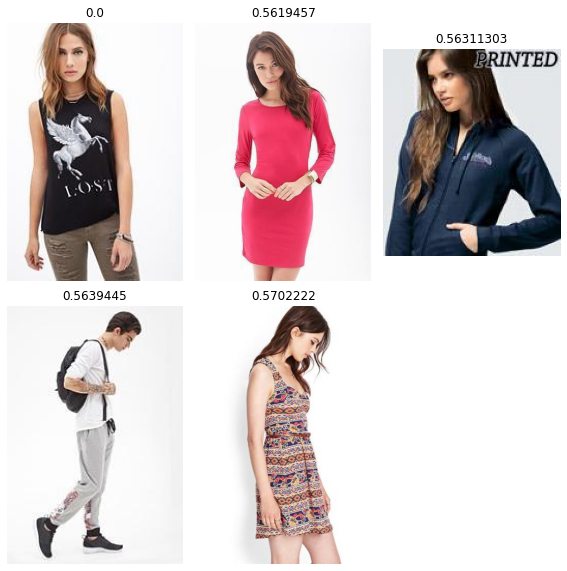

In [12]:
# img = Image.open(r"img/img/img_00000015.jpg")
# # Extract its features
# query = fe.extract(img)
# # Calculate the similarity (distance) between images
# dists = np.linalg.norm(features - query, axis=1)
# # Extract 30 images that have lowest distance
# ids = np.argsort(dists)[:30]
# scores = [(dists[id], img_paths[id]) for id in ids]
# # Visualize the result
# axes=[]
# fig=plt.figure(figsize=(8,8))
# for a in range(5):
#     score = scores[a]
#     axes.append(fig.add_subplot(2.5, 3, a+1))
#     subplot_title=str(score[0])
#     axes[-1].set_title(subplot_title)  
#     plt.axis('off')
#     plt.imshow(Image.open(score[1]))
# fig.tight_layout()
# plt.show()

In [25]:
def get_cut_img_paths(PATH_TO_CUTED_IMAGES):
    cut_img_paths_arr = []
    cut_dirs_classes = os.listdir(PATH_TO_CUTED_IMAGES)
    cut_dirs_classes.remove(backup_last_index_file_name)
    
    for cut_dirs_class in cut_dirs_classes:
        img_paths_of_class_wrong_format = list(Path("./" + PATH_TO_CUTED_IMAGES + '/' + cut_dirs_class).glob("*.*"))
        img_paths_of_class = list(map(lambda x: str(x), img_paths_of_class_wrong_format))
        cut_img_paths_arr.extend(img_paths_of_class)
#         for feature_path in :
#             print(feature_path)
    return cut_img_paths_arr

In [26]:
def find_class_and_cut_img(img_path):
    image = load_image_into_numpy_array(Image.open(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rembg = rembg(img_path)
    cv2.resize(image, (image_rembg.shape[0], image_rembg.shape[1]), interpolation = cv2.INTER_AREA)
    image_rembg_expanded = np.expand_dims(image_rembg, axis=0)
    output_dict = run_inference_for_single_image(image_rembg, detection_graph)
    index_of_max_score = np.where(output_dict['detection_scores'] == max(output_dict['detection_scores']))
    class_path = category_index[output_dict['detection_classes'][index_of_max_score][0]]['name']
    
    box_with_max_score = output_dict['detection_boxes'][index_of_max_score][0]
#     print('box_with_max_score', box_with_max_score)
    ymin, xmin, ymax, xmax = box2cords(box_with_max_score, image.shape[1], image.shape[0])
    image_cutted = image[ymin:ymax, xmin:xmax]
    
    return class_path, image_cutted

In [51]:
def find_similar_img(img, img_class, img_paths, count_of_similar):
    # Extract its features
    query = fe.extract(img)
    # Calculate the similarity (distance) between images
    dists = np.linalg.norm(features - query, axis=1)
    # Extract 30 images that have lowest distance
    ids = np.argsort(dists)[:count_of_similar]
    
    print(len(dists), len(img_paths))
    scores = [(dists[id], img_paths[id]) for id in ids]
    # Visualize the result
    axes=[]
    fig=plt.figure(figsize=(8,8))
    for a in range(count_of_similar):
        score = scores[a]
        axes.append(fig.add_subplot(5, 6, a+1))
        subplot_title=str(score[0])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        plt.imshow(Image.open(score[1]))
    fig.tight_layout()
    plt.show()

In [41]:
fe = FeatureExtractor()

329 329


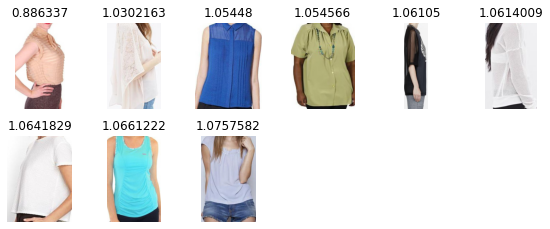

In [52]:
image_path = r"img/img/img_00000018.jpg"
img = Image.open(image_path)
img_class, cutted_img_arr = find_class_and_cut_img(image_path)
cut_img_paths = get_cut_img_paths(PATH_TO_CUTED_IMAGES)
cutted_img = Image.fromarray(np.uint8(cutted_img_arr)).convert('RGB')
find_similar_img(cutted_img, img_class, cut_img_paths, 9)

In [29]:
print(len(dists))
print(len(img_paths))
print(len(ids))

NameError: name 'dists' is not defined